# **IBM Data Science Specialisation - Capstone Project**
<div class="alert alert-block alert-info">
    <h2> Predicting automobile crash severity in New Zealand</h2>
    <h2> Fernando Castellanos - October 2020</h2>
</div>

This notebook illustrates the steps that have been taken for the analysis of historical New Zealand data of automobile crashes and associated severity. The analysis starts by describing the problem and its background, the description of the data, the exploration of the data and its cleaning, follow by modelling with several different machine learning engines.

*The annotations in this notebook are very succinct, for more detail descriptions please refer to the project report.*

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>The execution of this notebook takes SEVERAL HOURS. It is possible to reduce the execution time by commenting some of the most time consumning calculations: 1) in the section features correlation, comment out the generation of the correlation matrices, especially the ones using the full dataset, 2) in the function loop_clasf_engine comment out some of the classifiers, especially the KNeighborsClassifier which takes a long time to calculate.</blockquote>
</div>

#### == Importing libraries ==

In [1]:
# Libraries required to carry out the project
# Basic calculation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time

# Methods used to manage the unbalanced datasets
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

# Classification engines and support routines
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, 
                             f1_score, recall_score, precision_score, balanced_accuracy_score,
                            plot_confusion_matrix)

# Library containing several encoders
import category_encoders as ce

# dyton is a correlation algorithm that can take categorical and numerical values
# for more details:
#    https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9,
#    https://github.com/shakedzy/dython, http://shakedzy.xyz/dython/
from dython.nominal import associations

# phik is a correlation library implements a correlation coefficient 𝜙𝐾. This coefficient
# follows a uniform treatment for interval, ordinal and categorical variables,
# captures non-linear dependencies, and is similar to Pearson’s correlation coefficient
# in case of a bivariate normal input distribution. For more details:
# "A new correlation coefficient between categorical, ordinal and interval variables
# with Pearson characteristics". M. Baak, R. Koopman, H. Snoek, S. Klous. Computational
# Statistics and Data Analysis. 2018. https://arxiv.org/abs/1811.11440
# Package website: https://phik.readthedocs.io/en/latest/index.html
import phik
from phik import resources, report

#### == My functions ==

In [2]:
#
#  Function to facilitate the generation of countplot plots
#
def mycount_plot(my_counter, my_labelx, my_labely, my_title, my_ax, my_format='round', 
                 my_order=None, my_hue=None, my_hue_order=None, my_palette="nipy_spectral",mystyle='whitegrid'):
    # Arguments are self explanatory
    # my_format provides three values: deci the percentages are written with two decimals, round percentages 
    #                                are rounded to integer values, reducing the space required and
    #                                None to avoid percentage values
    sns.set_style(mystyle)
    sns.countplot(x=my_counter, data=crashes_NZ, hue=my_hue, hue_order=my_hue_order, palette=my_palette,
                  ax=my_ax, order=my_order)
    if  my_format != "None":
        for p in my_ax.patches:
            if my_format == 'deci':
                height = p.get_height()
                my_ax.text(p.get_x()+p.get_width()/2.,height + 10,'{:1.2f} %'.format(height*100/total),
                           ha="center")
            elif my_format == 'round':
                height = p.get_height()
                my_ax.text(p.get_x()+p.get_width()/2.,height + 10,'{:2} %'.format(int(height*100/total)),
                       ha="center")          
    my_ax.set(xlabel=my_labelx, ylabel=my_labely)
    my_ax.set_title(my_title)
    return

In [3]:
#
# Function to calculate percentages for value_counts of a column of a dataframe
#
def create_count_percentages(seriesnan, name=None):
    series = seriesnan.fillna('NaN')
    values = series.value_counts()
    expanded_value = values.to_frame(name)
    expanded_value['percent'] = values.apply(lambda _: _ / series.size * 100)
    print(expanded_value)
    return
#
# Data must be loaded before create_plot_data due to inside reference
#
def calc_percentages(data, feature):
    return create_count_percentages(data[feature], name=feature)


In [4]:
#
# Function to map the NaN, Unknown and other values to their crash severity type
#
def map_vacios(feature, val_unknown):
    if val_unknown == 'NaN':
        pre_value_slice = crashes_NZ[crashes_NZ[feature].isnull()]
        value_slice = pre_value_slice.copy()
        value_slice[feature].fillna('&&', inplace=True)
    else:     
        value_slice = crashes_NZ[crashes_NZ[feature] == val_unknown]
    list_samples = value_slice[[feature, 'crashSeverity']]
    print(list_samples.groupby('crashSeverity').count())
    return list_samples

In [5]:
#
# Function to fit and test different classification engines
#
def loop_clasf_eng (X_train_set, y_train_set, X_test, y_test):

    # Classifiers to use on the data
    
    classifiers = [    
        DecisionTreeClassifier(max_depth=10),
        HistGradientBoostingClassifier(),
        ComplementNB(),
        KNeighborsClassifier(),
        LinearSVC(dual=False, class_weight='balanced',max_iter=10000),
        LinearDiscriminantAnalysis()]
    y_labels = ['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash']

    #  Looping over the three sets of data - one unbalanced and two balanced
    total_results = pd.DataFrame(columns=['Dataset', 'Model', 'Severity', 
                                          'Precision', 'Recall', 'f1-score'])
    total_ave_results = pd.DataFrame(columns=['Dataset', 'Model', 'Ave. Precision',
                                              'Ave. Recall', 'Ave. f1-score',
                                             'Accuracy', 'Bal-Accuracy'])

    for indx, dataset_type in enumerate(datasets_names):
        X_train = Xs_train[indx]
        y_train = ys_train[indx]
        print('\n === Dataset === ', dataset_type)
        #Looping over the classifiers
        for model in classifiers:
            start_time = time.time()
            print('\nStart ', time.strftime("%X",time.localtime(start_time)))
            model_name = str(model).split("(")[0]
            # Instanciate the classifier, train it and calculate the predicted test response
            model_inst = model
            model_inst.fit(X_train, y_train)
            print('*** Model:', model, '  name', model_name)
            y_predict = model_inst.predict(X_test)
            
            # Calculating metrics per class to quantify quality of model results
            model_precision = precision_score(y_test, y_predict, labels=y_labels, average=None)
            model_recall = recall_score(y_test, y_predict, labels=y_labels, average=None)
            model_f1score = f1_score(y_test, y_predict, labels=y_labels, average=None)
            print(classification_report(y_test, y_predict, labels=y_labels,
                                     digits=5))
            # Calculating average metrics to quantify quality of model results
            model_ave_precision = precision_score(y_test, y_predict, labels=y_labels,
                                                  average='weighted')
            model_ave_recall = recall_score(y_test, y_predict, labels=y_labels,
                                            average='weighted')
            model_ave_f1score = f1_score(y_test, y_predict, labels=y_labels,
                                         average='weighted')           
            model_accuracy = accuracy_score(y_test, y_predict)
            model_balance_accuracy = balanced_accuracy_score(y_test, y_predict)

            
            # Merging the results
            for indme, sever in enumerate(y_labels):
                total_results = total_results.append({'Dataset':dataset_type, 'Model':model_name,
                                             'Severity':sever,
                                                 'Precision':model_precision[indme],
                                                 'Recall':model_recall[indme],
                                                 'f1-score':model_f1score[indme]},
                                                     ignore_index=True)
            total_ave_results = total_ave_results.append({'Dataset':dataset_type,
                                                     'Model':model_name, 
                                                      'Ave. Precision':model_ave_precision,
                                                         'Ave. Recall':model_ave_recall,
                                                         'Ave. f1-score':model_ave_f1score,
                                                         'Accuracy':model_accuracy,
                                                         'Bal-Accuracy':model_balance_accuracy},
                                                            ignore_index=True)
          
            print('\n Accuracy = {:7.5f}'.format(model_accuracy),
                  '    Ave. Accuracy = {:7.5f}'.format(model_balance_accuracy)
                    , '\n')
            end_time = time.time()
            diff_time = (end_time - start_time) + 43200
            print('Finish: ', time.strftime("%X",time.localtime(end_time)),
                '  Calculation time: ', time.strftime("%X",time.localtime(diff_time))) 

    return total_results, total_ave_results


In [6]:
#
# Function to superimpose three sworm plots for the classification metrics
#
def colmena(algorit_group, algorit_name):

    # Plot initialisation
    plt.figure(figsize=(12,7))
    palette_blue = ['#000099', '#0099FF', '#00FFFF', '#dce9ef']
    palette_red = ['#FF3300', '#FF9900', '#fec77f', '#FFFF00']
    palette_green = ['#003300', '#339900', '#33FF00', '#9fc55a']

    # Three superimpose plots for the metrics: Precision, Recall and f1-score
    my_plot = sns.swarmplot(x='Dataset', y='Precision', data=algorit_group, hue='Severity',
              dodge=False, palette=palette_blue, size=15,
                       edgecolor='gray', linewidth=1.0)
    my_plot = sns.swarmplot(x='Dataset', y='Recall', data=algorit_group, hue='Severity',
              dodge=False, palette=palette_red, size=15,
                       edgecolor='gray', linewidth=1.0)
    my_plot = sns.swarmplot(x='Dataset', y='f1-score', data=algorit_group, hue='Severity',
              dodge=False, palette=palette_green, size=15,
                       edgecolor='gray', linewidth=1.0)
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    my_plot.set_xlabel('Dataset')
    my_plot.set_ylabel('Precision - Recall - f1-score')
    my_plot.set_xticklabels(['Full Set', 'Over-sampled', 'Under-sampled'])
    my_plot.set_title('Results for model ' + algorit_name +  
                          ' --   (Blue: Precision, Red: Recall, Green: f1-score)')
    plt.show()
    return
    

In [7]:
#
# Function to plot the confusion matrix for different classification engines
#

def confus_matx(name_dset, model, X_train, y_train, X_test, y_test):
    y_labels = ['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash']
    start_time = time.time()
    print('\nStart ', time.strftime("%X",time.localtime(start_time)))
    model_name = str(model).split("(")[0]
    # Instanciate the classifier, train it and calculate the predicted test response
    if str(model) == 'LinearSVC()':
        model = LinearSVC(dual=False, class_weight='balanced',max_iter=10000)
    model_inst = model
    model_inst.fit(X_train, y_train)
    y_predict = model_inst.predict(X_test)        
        
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plot_confusion_matrix(model_inst, X_test, y_test, cmap='mako_r',
                                    labels=y_labels, ax=ax)
    plt.title('Dataset: '+name_dset+'     Model: '+model_name)
    plt.show
    end_time = time.time()
    diff_time = (end_time - start_time) + 43200
    print('Finish: ', time.strftime("%X",time.localtime(end_time)),
        '  Calculation time: ', time.strftime("%X",time.localtime(diff_time))) 

    return


<div class="alert alert-block alert-success">

## Business Problem / Problem Description and Background

According to the World Health Organization, road traffic injuries caused an estimated 1.35 million deaths worldwide in the year 2016. The report indicates that  road traffic injuries are currently the leading cause of death for children and young adults. These statistics show that even with all the safety devices installed in modern cars, fatalities due to automobile crashes still happening in high numbers. Hence, it is important to have tools to help reduce the number of accidents and their related fatalities.

#### == Interest / target audience ==

Thanks to the advancement of data collection and data analysis, it is possible nowadays to better understand how automobile crashes happen and how to predict their outcome (severity). Practical use of such a predictive tool would enable the transport, security and emergency local agencies to analyse incoming reports of accidents and been able to determine on-line the possible severity of such a crash. This can be used to dispatch the adequate emergency response and activate any traffic controls. Hence, my goal is to predict the severity of a given automobile crash sample.

## The Dataset - Features and Target

#### == Data source ==

The selected crash data for this project is taken from the New Zealand Transport Agency. More information about the data can be found in my report and at the ["Crash Analysis System (CAS) data'](https://opendata-nzta.opendata.arcgis.com/datasets/crash-analysis-system-cas-data-1) website. The crash data provides information about each traffic crash reported by the New Zealand Police since 1 January 2000. The dataset is available on various formats, I have chosen the CSV file. However, the file is quite big, so it is distributed as a zip file at this webpage with ["Disaggregated crash data"](https://nzta.govt.nz/safety/safety-resources/road-safety-information-and-tools/disaggregated-crash-data/). Additionally, there is a metafile with the description of all the features available in the dataset. I have organised a clearer list that can be found in the Appendix of my report.

#### == Reading the data ==

The size of the file containing all the records is 199 MB and its corresponding compressed zip file is 31 MB. Files of this size are not possible to upload in Github. Hence, I have installed a copy of the original data file in my Dropbox account to overcome this issue and be able to load the data file from this notebook.

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>The dataset is quite large and it will take sometime to upload, please wait.</blockquote>
</div>

In [8]:
# Reading of the data file housed in my Dropbox account, due to its large size (See above).
# The dataset is stored in the dataframe crashes_NZ
#
# ----- The dataset is quite large and it will take sometime to load, please wait ------
url_data = 'https://www.dropbox.com/s/kz22jci2272268j/Crash_Analysis_System__CAS__Data.csv?dl=1'
crashes_NZ = pd.read_csv(url_data)

#### == Initial Look At The Dataset ==

In [9]:
# Determine the size of the dataset, obtain a  list of features with some inforamtion and a look at the initial
# values of the dataframe with head
print('\n','The dataset has ',crashes_NZ.shape[0], 'samples and ',crashes_NZ.shape[1],'features','\n')
print('\n', crashes_NZ.info())
pd.set_option('display.max_columns', 80)
crashes_NZ.head()


 The dataset has  725548 samples and  72 features 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725548 entries, 0 to 725547
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          725548 non-null  float64
 1   Y                          725548 non-null  float64
 2   OBJECTID                   725548 non-null  int64  
 3   advisorySpeed              26532 non-null   float64
 4   areaUnitID                 725513 non-null  float64
 5   bicycle                    725543 non-null  float64
 6   bridge                     285232 non-null  float64
 7   bus                        725543 non-null  float64
 8   carStationWagon            725543 non-null  float64
 9   cliffBank                  285232 non-null  float64
 10  crashDirectionDescription  725548 non-null  object 
 11  crashFinancialYear         725548 non-null  int64  
 12  crashLocation1             725548

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashRoadSideRoad,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,holiday,houseOrBuilding,intersection,kerb,light,meshblockId,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,pedestrian,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,temporarySpeedLimit,tlaId,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1.717767e+06,6.044764e+06,1222769,NaN,503300.0,0.0,NaN,0.0,2.0,NaN,West,2019,014-0000,KIRIKIRI STREAM LANE,NaN,Non-Injury Crash,Yes,2019,NaN,West,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Bright sun,105800.0,0.0,0.0,0.0,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Northland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Off,0.0,0.0,NaN,2.0,Whangarei District,Unknown,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
1,1.838763e+06,5.659130e+06,1222770,45.0,541501.0,0.0,0.0,0.0,1.0,0.0,North,2003,SH 1N,RANGIPO INTAKE ROAD,NaN,Non-Injury Crash,Yes,2003,0.0,North,0.0,0.0,0.0,Hill Road,1.0,NaN,0.0,NaN,0.0,Overcast,1289001.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,Waikato Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,100.0,0.0,Null,0.0,0.0,NaN,21.0,Taupo District,Nil,0.0,1.0,0.0,0.0,0.0,0.0,Open,0.0,0.0,0.0,Light rain,Null
2,1.771730e+06,5.899005e+06,1222771,NaN,523912.0,0.0,NaN,0.0,2.0,NaN,South,2017,PORCHESTER ROAD,AIRFIELD ROAD,NaN,Non-Injury Crash,No,2016,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Overcast,765401.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Null,0.0,0.0,NaN,76.0,Auckland,Unknown,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Null,Null
3,1.763327e+06,5.917684e+06,1222772,NaN,516301.0,0.0,0.0,0.0,2.0,0.0,North,2017,DORCHESTER ST,ST JOHNS ROAD,NaN,Non-Injury Crash,No,2016,0.0,North,0.0,0.0,0.0,Hill Road,0.0,NaN,0.0,NaN,0.0,Overcast,461200.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,Auckland Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,Null,0.0,0.0,NaN,76.0,Auckland,Stop,0.0,0.0,0.0,1.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine,Null
4,1.767530e+06,5.466098e+06,1222773,NaN,566102.0,0.0,0.0,0.0,0.0,0.0,East,2006,POPLAR AVENUE,LEINSTER AVENUE,NaN,Non-Injury Crash,No,2005,0.0,East,0.0,0.0,0.0,Flat,0.0,NaN,0.0,NaN,0.0,Overcast,2007600.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,Wellington Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,100.0,0.0,Null,0.0,0.0,NaN,43.0,Kapiti Coast District,Nil,0.0,0.0,0.0,0.0,0.0,0.0,Open,1.0,0.0,0.0,Fine,Null


A complete listing of the features with their descriptions can be found in the report Appendix.
The dataset contains categorical and numerical features, with some of them e.g *'X'* and *'Y'*, representing spatial geodata to indicate the precise location of the crash site. Additionally, it is possible to observe that some features are missing values and two of them do not have any values.

#### == The target feature (crash severity) - *'crashSeverity'* ==

In [10]:
# Having a closer look at the target feature - 'crashSeverity'
print("Number of samples per category for 'crashSeverity'")
crashes_NZ['crashSeverity'].value_counts(dropna=False)

Number of samples per category for 'crashSeverity'


Non-Injury Crash    515182
Minor Crash         163479
Serious Crash        40300
Fatal Crash           6587
Name: crashSeverity, dtype: int64

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

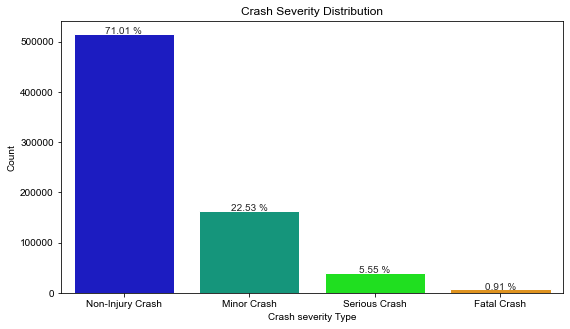

In [11]:
# Plot the count values for crash severity
#
total = float(len(crashes_NZ))
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
plot_order = ['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash']
mycount_plot('crashSeverity', 'Crash severity Type', 'Count', 'Crash Severity Distribution', ax,
             my_order=plot_order, my_format='deci')
plt.show()

The target feature, representing the severity of the crash is *'crashSeverity'*.
It is a categorical feature, with a full set of values (725548). The feature has four classes (*Non-Injury Crash, Minor Crash, Serious Crash and Fatal Crash*) and is quite an unbalanced distribution, given the fact that the possibility of a crash being a fatal one is very small, compared with the possibility of being a minor one, without injuries. The plot shows the contrast between *'Fatal Crash'*, which just below 1% of the total of samples, and *'Non-injury Crash'*, with just over 71% of the samples. This unbalanced is something that has to be addressed later.

## Data Cleaning and Preparation

#### == Data wrangling - Removal of non-relevant features ==

The dataset is quite big, it contains 725548 samples each with 72 features, including the target one which we will try to predict. Examining the list of features and their descriptions (Appendix of the report), it is apparent that not all them are of interest for our goal of predicting the crash severity. Hence, it is possible to disregard some features from the beginning, later we might need to remove additional features. The initial features to drop are:

* *X, Y* = geo location of the crash site - very precise location of the crash site is not required for this project
* *OBJECTID* = unique crash identification - is not use for this project
* *areaUnitID* = unique identifier of an area unit - unclear definition, is not use for this project
* *crashDirectionDescription* = geo direction reference - unclear definition, is not use for this project
* *crashFinancialYear, crashYear* = financial and calendar year at time the crash occurred - is not use for the project as analysis is not looking at evolution in time
* *crashLocation1* and *crashLocation2* = description of the crash location, using traffic and landmark markers. These two features are very specific to the crash location and because of this no two samples are the same. This large amount of possibilities(classes) makes them of not use for this project.
* *fatalCount, seriousInjuryCount and minorInjuryCount* = number of fatalities or people injured during the crash - is not use for the project and they are correlated to our target (crash severity)
* *meshblockID* = unique block identifier - unclear definition, is not use for this project
* *region* = geographical region where crash occurred. This feature provides a reference to large areas of the country, instead the project will use the feature *'tlaName'* which provides a more discrete sectionalisation. Additionally, the number of data samples for *'region'*, *'tlaName'* and *'tlaId'* is the same, so there is not benefit in keeping the three of them. Hence, '*region'* will be dropped.
* *tlaId* = unique identifier for a territorial local authority, instead the project will use the names.

The initial information on the dataset list showed that there are two features that have no data, hence both will be dropped:
* *intersection* = indicates if the crash happened at an intersection
* *crashRoadSideRoad* = indicates if the main car was on the crash road or side road

Additionally, there are some features that have less than 29000 non-NaN values (which represents less than 4% of the total data for a feature). That amount of data is too small to analyse correlations and help with our modelling. Two of these features are: *temporarySpeedLimit* and *advisorySpeed* which are displayed in the plot below.

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

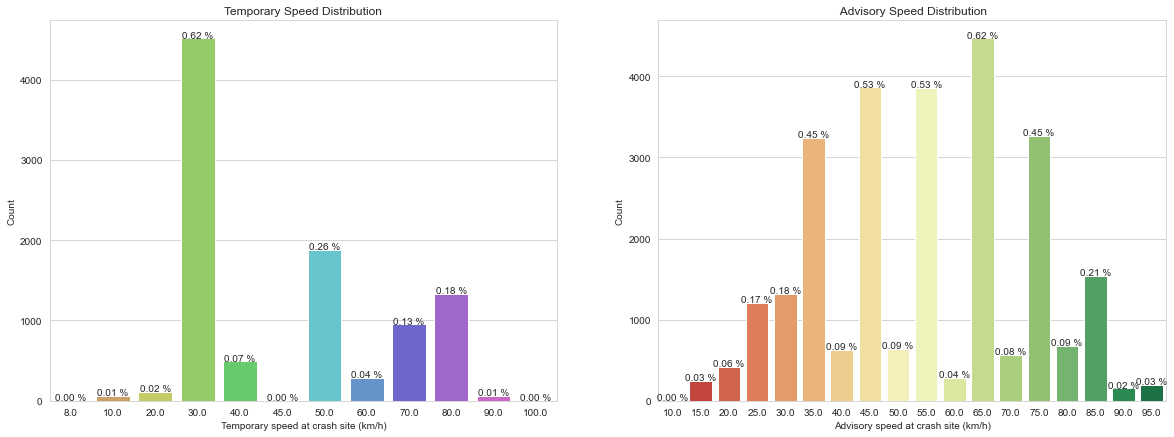

In [12]:
# Looking at temporarySpeedLimit and advisorySpeed
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 7)
mycount_plot('temporarySpeedLimit', 'Temporary speed at crash site (km/h)', 'Count', 'Temporary Speed Distribution', ax1, 
             my_format='deci', my_palette='hls')
mycount_plot('advisorySpeed', 'Advisory speed at crash site (km/h)', 'Count', ' Advisory Speed Distribution', ax2,
             my_format='deci', my_palette='RdYlGn')
plt.show()

Calculating the full data distribution for *'temporarySpeedLimit'* and *'advisorySpeed'* among their respective classes

In [13]:
calc_percentages(crashes_NZ, 'temporarySpeedLimit')

       temporarySpeedLimit    percent
NaN                 715872  98.666387
30.0                  4513   0.622013
50.0                  1875   0.258425
80.0                  1330   0.183310
70.0                   951   0.131073
40.0                   490   0.067535
60.0                   281   0.038729
20.0                   110   0.015161
90.0                    62   0.008545
10.0                    61   0.008407
100.0                    1   0.000138
45.0                     1   0.000138
8.0                      1   0.000138


In [14]:
calc_percentages(crashes_NZ, 'advisorySpeed')

      advisorySpeed    percent
NaN          699016  96.343178
65.0           4466   0.615535
45.0           3862   0.532287
55.0           3858   0.531736
75.0           3268   0.450418
35.0           3235   0.445870
85.0           1535   0.211564
30.0           1314   0.181104
25.0           1201   0.165530
80.0            676   0.093171
50.0            640   0.088209
40.0            624   0.086004
70.0            562   0.077459
20.0            421   0.058025
60.0            284   0.039143
15.0            240   0.033078
95.0            192   0.026463
90.0            153   0.021088
10.0              1   0.000138


From the data and the graphs is possible to see that:
* *temporarySpeedLimit* = temporary speed limit at site of the crash (eg due to road works) -- it has only 9676 values, representing less than 2% - the largest class represents only 0.62%.
* *advisorySpeed* = advisory speed at the crash site -- it has only 26532 values, representing less than 4% - the largest class represents only 0.62%.

These two features do not have a good amount of data and most probably they have suffered of missing values during the data input at the crash site. Hence, the two features will be dropped.

#### == Removing non-relevant features ==

Following the previous section several features are dropped from the dataset

In [15]:
# Removing non-relevant features 
drop_columns = ['X', 'Y', 'OBJECTID', 'areaUnitID', 'crashDirectionDescription', 'crashFinancialYear', 'crashYear', 
                'crashLocation1', 'crashLocation2','fatalCount', 'meshblockId', 'minorInjuryCount', 'region', 
                'seriousInjuryCount', 'tlaId','intersection', 'crashRoadSideRoad', 'temporarySpeedLimit',
                'advisorySpeed']
crashes_NZ.drop(drop_columns, axis=1, inplace=True)
#
# Checking the new dimensions of the dataset
crashes_NZ.shape

(725548, 53)

## Data Exploration

### Data wrangling - missing data, sanitation

From the features list it was noticeable that many of them have missing(NaN) data, a closer inspection shows that the majority of them are counters providing details about a variety of objects that could be involved in the crash (e.g *'bicycle'* indicates how many bicycles were involved in the crash, *'postOrPole'* indicates how many poles or posts were hit during the crash). Most probably this missing data corresponds to intentionally left blank values during the data input at the crash site. Hence, if it was left as a blank it indicates that the feature is not applicable to the specific crash event and it can be replaced by a value of zero(0). 

The counters to replace missing values are: *bicycle, bridge, bus, carStationWagon, cliffBank, debris, ditch, fence, guardRail, houseOrBuilding, kerb, moped, motorcycle, objectThrownOrDropped, otherObject, otherVehicleType, overBank, parkedVehicle, pedestrian, phoneBoxEtc, postOrPole, roadworks, schoolBus, slipOrFlood, strayAnimal, suv, taxi, trafficIsland, trafficSign, train, tree, truck, unknownVehicleType, vanOrUtility, vehicle and waterRiver*.  

In [16]:
# Replacement of NaN values with 0 for counters
replacement= {'bicycle':0,'bridge': 0,'bus':0,'carStationWagon':0,'cliffBank':0,'debris':0,'ditch':0,'fence':0,
             'guardRail':0,'houseOrBuilding':0,'kerb':0,'moped':0,'motorcycle':0,'objectThrownOrDropped':0,
             'otherObject':0,'otherVehicleType':0,'overBank':0,'parkedVehicle':0,'pedestrian':0,'phoneBoxEtc':0,
             'postOrPole':0,'roadworks':0,'schoolBus':0,'slipOrFlood':0,'strayAnimal':0,'suv':0,'taxi':0,
             'trafficIsland':0,'trafficSign':0,'train':0,'tree':0,'truck':0,'unknownVehicleType':0,
             'vanOrUtility':0,'vehicle':0,'waterRiver':0}
crashes_NZ.fillna(value=replacement, inplace=True)

# Having a look at the list of features and NaN values

crashes_NZ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725548 entries, 0 to 725547
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bicycle                   725548 non-null  float64
 1   bridge                    725548 non-null  float64
 2   bus                       725548 non-null  float64
 3   carStationWagon           725548 non-null  float64
 4   cliffBank                 725548 non-null  float64
 5   crashSeverity             725548 non-null  object 
 6   crashSHDescription        725518 non-null  object 
 7   debris                    725548 non-null  float64
 8   directionRoleDescription  725430 non-null  object 
 9   ditch                     725548 non-null  float64
 10  fence                     725548 non-null  float64
 11  flatHill                  725548 non-null  object 
 12  guardRail                 725548 non-null  float64
 13  holiday                   39589 non-null   o

The list above shows that there are a few more features that have NaN values. The possible options to resolve these values are: 1) one option is to remove the samples with NaN values, 2) another option would be to replace these NaN values with appropriate ones, following some logic criteria to replace them and 3) the last option is to remove the corresponding samples from the dataset. However, this last option has to be considered carefully, as per by removing the samples we might influence the distribution of the dataset with respect to the  crash severity (e.g. it will not be advisable to delete a large portion of samples that have *'Fatal Crash'*, as their numbers are very low to start with).
Looking initially at the features and their context in the dataset the following possible solutions are proposed:

* *speedLimit* = traffic speed limit at the crash site-- Using the fact that most urban areas in New Zealand have a speed limit of 50 km/h and 100 km/h for outside urban areas, it could be possible to replace the NaN values. The feature *'urban'* provides the information (urban or not) for each crash event and this can be mapped to replace the NaN values accordingly to the crash location. Because this replacement requires the use of another column as a lookup reference, it is not possible to use a simple replace function for the substitution.
* *tlaName* = Local authority where crash occurred -- Any NaN value could be replaced with *'Unknown'* as there is not a way to determine an appropriated replacement value.
* *NumberOfLanes* = Number of lanes at road crash site -- Any NaN value could be replaced with *'2'* (two lanes) as this is the most common number of lanes in New Zealand.
* *holiday* = Indicates whether the crash happened during a holiday -- Any NaN value could be replaced with *'None'* as NaN most probably means that there was not a holiday at the time of the crash and the entry was left blank.
* *directionRoleDescription* = Direction of the principal vehicle involve in the crash -- Any NaN and Null value could be replaced with *'Unknown'* as there is not a way to determine a replacement value.

Now, we go further into the analysis to see which are best options.

#### == Analysis for *'speedLimit'* (speed limit at crash site) ==

Calculation of its classes data distribution and the distribution of the 'NaN' samples with respect crash severity

In [17]:
# Calculation of the full distribution of values for 'speedLimit'
calc_percentages(crashes_NZ, 'speedLimit')

       speedLimit    percent
50.0       440981  60.779025
100.0      199988  27.563717
80.0        33098   4.561793
70.0        23134   3.188486
60.0        18319   2.524850
30.0         5653   0.779135
20.0         1820   0.250845
40.0         1049   0.144580
10.0          618   0.085177
NaN           492   0.067811
90.0          338   0.046585
110.0          46   0.006340
15.0            6   0.000827
5.0             5   0.000689
6.0             1   0.000138


In [18]:
# Distribution of 'speedLimit' samples with NaN in terms of crash severity
NaN_list_speedLimit = map_vacios('speedLimit', 'NaN')

                  speedLimit
crashSeverity               
Fatal Crash                1
Minor Crash               14
Non-Injury Crash         470
Serious Crash              7


<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

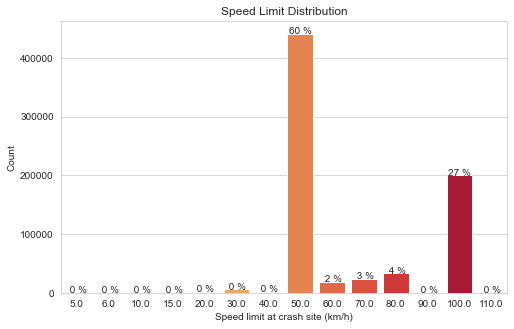

In [19]:
# Looking at the distribution of 'speedLimit'
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
mycount_plot('speedLimit', 'Speed limit at crash site (km/h)', 'Count', 'Speed Limit Distribution', ax, my_format='round', 
             my_palette='YlOrRd')
plt.show()

From the data and the graph it is possible to see that the most common speeds are 50 and 100 km/h, 
supporting the idea of how to substitute the NaN values. From the total of 492 samples with NaN, only one corresponds
to a *'Fatal Crash'* and the large majority are *'Non-Injury Crash'*, therefore this set of samples could be replaced with 
very few influence on the balance of the dataset. Hence, the NaN values are replace by 50 or 100 km/h depending on the *'urban'* value.

Replacing *'NaN'* values for *'SpeedLimit'*

In [20]:
# Replacing NaN values for 'SpeedLimit' 
crashes_NZ.loc[((pd.isna(crashes_NZ['speedLimit'])) & (crashes_NZ['urban'] == 'Urban')), 'speedLimit'] = 50.0
crashes_NZ.loc[((pd.isna(crashes_NZ['speedLimit'])) & (crashes_NZ['urban'] == 'Open')), 'speedLimit'] = 100.0

#### == Analysis for *'tlaName'* (local authority at the site crash) ==

Calculation of its classes data distribution and the distribution of the 'NaN' samples with respect crash severity

In [21]:
# Calculation of the full distribution of values for 'tlaName'
calc_percentages(crashes_NZ, 'tlaName')

                           tlaName    percent
Auckland                    258604  35.642576
Christchurch City            47575   6.557113
Wellington City              29294   4.037500
Hamilton City                25167   3.468688
Dunedin City                 22253   3.067061
...                            ...        ...
Kaikoura District             1110   0.152988
Carterton District            1109   0.152850
Kawerau District               312   0.043002
Chatham Islands Territory      171   0.023568
NaN                             35   0.004824

[68 rows x 2 columns]


In [22]:
# Distribution of 'tlaName' samples with NaN in terms of crash severity
NaN_list_tlaName = map_vacios('tlaName', 'NaN')

                  tlaName
crashSeverity            
Minor Crash             1
Non-Injury Crash       33
Serious Crash           1


In [23]:
# There are too many local authorities (68 classes) to show in a single plot.
# Hence, for clarity only 14 classes with largest counters are used for the plot
# Data preparation for the plot
#
tla_series = crashes_NZ['tlaName'].fillna('NaN')
tla_counters = tla_series.value_counts()
tla_expanded = tla_counters.to_frame('tlaName')
tla_expanded.reset_index(inplace=True)
tla_expanded.columns = ['Local Authority', 'Count']
plot_tla_sh = tla_expanded.iloc[0:14,:]
plot_tla = plot_tla_sh.replace(regex=['City','District'], value='')

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

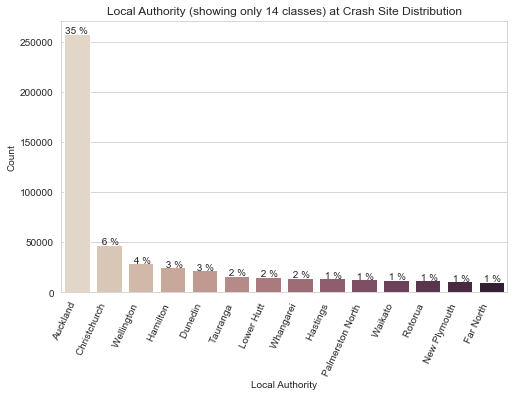

In [24]:
# Plotting the distribution of 'tlaName'
# As the plot for a 'tlaName' is just plotting a few classes, a manual way to plot is used

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

fig = plt.gcf()
chart = sns.barplot(x="Local Authority", y="Count", palette="ch:.25", data=plot_tla, ax=ax)
for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 10,'{:2} %'.format(int(height*100/total)), ha="center")          
chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
ax.set_title('Local Authority (showing only 14 classes) at Crash Site Distribution')
plt.show()

The data analysis and graph above indicate that there are 35 values missing(NaN), of those the large majority
are *'Non-Injury Crash'* and there are none *'Fatal Crash'*. Therefore, for this case seems better to drop the corresponding 35 samples given their low number, as their deletion could be considered of not consequence for the analysis and modeling. The data behaves as expected, with most of the crashes occurring in the main cities: Auckland - with a large percentage -, Christchurch, Wellington, Hamilton and Dunedin.

Dropping 35 'NaN' samples for *'tlaName'*

In [25]:
# Dropping 35 NaN samples for tlaName
crashes_NZ.drop(NaN_list_tlaName.index, inplace=True)

#### == Analysis for *'NumberOfLanes'*  (number of lanes at crash road) ==

Calculation of its classes data distribution and the distribution of the 'NaN' and O values samples with respect crash severity

In [26]:
# Calculation of the full distribution of values for 'NumberOfLanes'
calc_percentages(crashes_NZ, 'NumberOfLanes')

     NumberOfLanes    percent
2.0         533329  73.510606
4.0          80830  11.141082
3.0          49960   6.886162
1.0          27292   3.761752
5.0          12421   1.712030
6.0          10383   1.431125
0.0           8859   1.221067
NaN           1193   0.164435
8.0            690   0.095105
7.0            552   0.076084
9.0              4   0.000551


In [27]:
# Distribution of 'NumberOfLanes' samples with NaN in terms of crash severity
NaN_list_NumberOfLanes = map_vacios('NumberOfLanes', 'NaN')

                  NumberOfLanes
crashSeverity                  
Fatal Crash                  13
Minor Crash                 491
Non-Injury Crash            511
Serious Crash               178


In [28]:
# Distribution of 'NumberOfLanes' samples with value 0 in terms of crash severity
N0_list_NumberOfLanes = map_vacios('NumberOfLanes', 0.0)

                  NumberOfLanes
crashSeverity                  
Fatal Crash                  61
Minor Crash                1351
Non-Injury Crash           6895
Serious Crash               552


<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

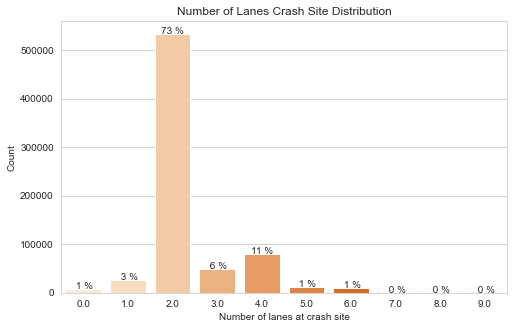

In [29]:
# Looking at the distribution of 'NumberOfLanes'
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
mycount_plot('NumberOfLanes', 'Number of lanes at crash site', 'Count', 'Number of Lanes Crash Site Distribution', ax,
             my_format='round', my_palette='Oranges')
plt.show()

The data analysis and graph above indicate that there are 1193 values missing(NaN), of those 13 are class *'Fatal Crash'* and the rest divided into the other three classes. This feature shows something surprising, there are 8859 samples with a value of 0 number of lanes, of those 61 are *'Fatal Crash'* and a large majority are *'Non-Injury Crash'*. There is no explanation in the description list for this value and there is not an apparent relation to other features. The samples with value 0 will be left as removing such a large number of samples could have a repercussion on the balance/composition of the dataset. The missing values will be replace by '2 lanes', which is the most common value.

Replacing *'NaN'* values with 2 for *'NumberOfLanes'*

In [30]:
# Replacing of NaN values for 'NumberOfLanes'
crashes_NZ['NumberOfLanes'].fillna(2, inplace=True)

#### == Analysis for *'holiday'* (crash occurred during a holiday) ==

Calculation of its classes data distribution

In [31]:
# Calculation of the full distribution of values for 'holiday'
calc_percentages(crashes_NZ, 'holiday')

                    holiday    percent
NaN                  685925  94.543447
Christmas New Year    18211   2.510086
Easter                 8390   1.156423
Queens Birthday        6803   0.937681
Labour Weekend         6184   0.852362


<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

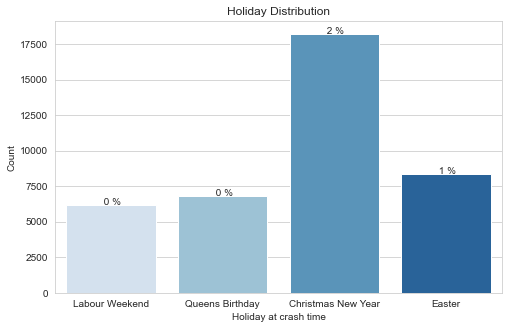

In [32]:
# Looking at the distribution of 'holiday'
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
mycount_plot('holiday', 'Holiday at crash time', 'Count', 'Holiday Distribution', ax,
             my_format='round', my_palette='Blues')
plt.show()

The data distribution shows that most of the data corresponds to missing values(NaN), 94.5% of the total. Because of this large value, there is no need for the composition analysis in terms of crash severity, as there would be a large number of *'Fatal Crash'*. Looking at the feature description it mentions that there is a possible *'None'* class, which has not been included in the dataset. However, it is clear that the 'None' class is there to represent days outside the holidays and most probably the *'NaN'* values in the dataset represent the same type of no-holiday days. It is quite possible that at the crash site when entering the data for the sample, the field for *'holiday'* has been skipped, leaving a blank for no-holiday days. Hence, the *'NaN'* values will be replaced with *'None'*.

Replacing *'NaN'* values with *'None'* for *'holiday'*

In [33]:
# Replacing NaN values with 'None' for 'holiday'
crashes_NZ['holiday'].fillna('None', inplace=True)

#### == Analysis for *'directionRoleDescription'* (direction of the main vehicle at the crash site) ==

Calculation of its classes data distribution and the distribution of the *'NaN'* and *'Null'* samples with respect crash severity

In [34]:
# Calculation of the full distribution of values for 'directionRoleDescription'
calc_percentages(crashes_NZ, 'directionRoleDescription')

       directionRoleDescription    percent
North                    222581  30.679119
South                    211581  29.162951
East                     145117  20.001985
West                     143046  19.716532
Null                       3070   0.423149
NaN                         118   0.016264


In [35]:
# Distribution of the corresponding samples(rows) with NaN in terms of crash severity
NaN_list_directionRoleDescription = map_vacios('directionRoleDescription', 'NaN')

                  directionRoleDescription
crashSeverity                             
Fatal Crash                              4
Minor Crash                             63
Non-Injury Crash                        34
Serious Crash                           17


In [36]:
# Distribution of the corresponding samples(rows) with Null in terms of crash severity
Null_list_directionRoleDescription = map_vacios('directionRoleDescription', 'Null')

                  directionRoleDescription
crashSeverity                             
Fatal Crash                              2
Minor Crash                            160
Non-Injury Crash                      2852
Serious Crash                           56


<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plot below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

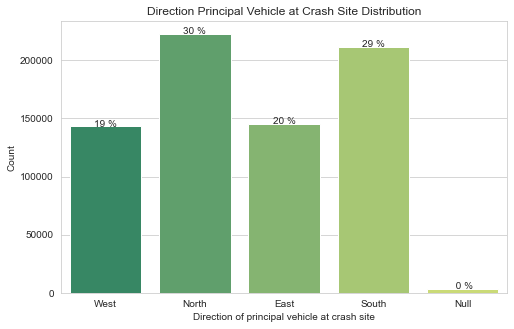

In [37]:
# Looking at the distribution of 'directionRoleDescription'
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
mycount_plot('directionRoleDescription', 'Direction of principal vehicle at crash site', 'Count', 
             'Direction Principal Vehicle at Crash Site Distribution', ax, my_format='round', 
             my_palette='summer')
plt.show()

The data and graph show that the data is quite balanced among the four cardinal points. However, there is data under two other different classes, *'NaN'* and *'Null'*. The feature description does not included *'Null'* as a possible class, but there are 3070 samples that have this value and only 2 of those are *'Fatal Crash'*. The large majority of these *'Null'* samples are *'Non-Injury Crash'*. Additionally, there are 118 samples with missing values (NaN), only 4 of them are *'Fatal Crash'*. The rest of the missing data splits among the other crash severity classes, with *'Minor Crash'* being the largest.

It is clear that this feature can only take one of the four cardinal points classes. The *'Null'* values seem like a mistake, given that there is no such a class and the missing (NaN) values seem like forgotten data. From the data we can summarise that these two classes, *'Null'* and *'NaN'* represent a total of 3188 samples, but only 6 of them are *'Fatal Crash'*. As there is not a way to replace any of these values with an appropriate value (e.g. derive from another feature) and there are only a few *'Fatal Crash'* samples in the group, it is prudent to drop the samples corresponding to the *'Null'* and *'NaN'* values.

Dropping 3188 *'Null'* and *'NaN'* samples for *'directionRoleDescription'*

In [38]:
# Dropping 3188 Null and NaN samples for 'directionRoleDescription'
crashes_NZ.drop(NaN_list_directionRoleDescription.index, inplace=True)
crashes_NZ.drop(Null_list_directionRoleDescription.index, inplace=True)

### Data Wrangling - Review Categorical Features, Sanitation
This   presents a brief analysis of each categorical feature, to examine the sanity of the data and some of its characteristics.

#### == Analysis for *'crashSHDescription'* (indicates if the crash occurred in a State Highway) ==

Calculation of its classes data distribution

In [39]:
# Calculation of the full distribution of values for 'crashSHDescription'
calc_percentages(crashes_NZ, 'crashSHDescription')

         crashSHDescription    percent
No                   509479  70.533209
Yes                  212804  29.460977
Unknown                  42   0.005815


The data shows that only around 30% of the crashes occur on a Highway. The feature description indicates that one of the possible values is *'Unknown'*, so this class is valid. A graph of the data is shown further below.

#### == Analysis for *'flatHill'* (indicates if the road where the crash occurred is flat or hilly) ==

Calculation of its classes data distribution and the distribution of the 'Null' samples with respect crash severity

In [40]:
# Calculation of the full distribution of values for 'flatHill'
calc_percentages(crashes_NZ, 'flatHill')

           flatHill    percent
Flat         578926  80.147579
Hill Road    140284  19.421175
Null           3115   0.431246


In [41]:
# Distribution of the corresponding samples(rows) with Null in terms of crash severity
Null_list_flatHill = map_vacios('flatHill', 'Null')

                  flatHill
crashSeverity             
Fatal Crash              7
Minor Crash            318
Non-Injury Crash      2688
Serious Crash          102


The data shows that most of the crashes (80%) occur on flat terrain. The feature description indicates that *'Null'* is not one of the possible classes. Looking at the composition of the 3115 *'Null'* samples in terms of their crash severity, it shows that only 7 samples are *'Fatal Crash'* and most of the values are *'Non-Injury Crash'*. This distribution shows that removing the *'Null'* samples from the dataset would not alter its balance. Hence, the samples would be removed from the dataset. A graph of the data is shown further below.

Dropping 3115 *'Null'* samples for *'flathill'* 

In [42]:
# Dropping 3115 Null samples for 'flatHill'
crashes_NZ.drop(Null_list_flatHill.index, inplace=True)

#### == Analysis for *'light'* (indicates the natural light at the time and place of the crash site) ==

Calculation of its classes data distribution

In [43]:
# Calculation of the full distribution of values for 'light'
calc_percentages(crashes_NZ, 'light')

             light    percent
Bright sun  269948  37.533961
Overcast    218330  30.356919
Dark        195760  27.218754
Twilight     33580   4.669012
Unknown       1592   0.221354


The distribution indicates that most of the data is more or less equally distributed among three classes: *'Bright sun'*, *'Overcast'* and *'Dark'*. The feature definition indicates that *'Unknown'* is a possible class, so there is not a problem with this class. A graph of the data is shown further below.

#### == Analysis for *'roadCharacter'* (general nature of the road at the crash site) ==

Calculation of its classes data distribution

In [44]:
# Calculation of the full distribution of values for 'roadCharacter'
calc_percentages(crashes_NZ, 'roadCharacter')

               roadCharacter    percent
Nil                   693768  96.462507
Bridge                 13861   1.927254
Motorway ramp           9362   1.301706
Rail xing               1752   0.243601
Overpass                 186   0.025862
Speed hump               137   0.019049
Underpass                 88   0.012236
Tunnel                    46   0.006396
Tram lines                10   0.001390


The distribution indicates that most of the data is of class *'Nil'* and the feature description shows that this is a valid class. The *'Nil'* value can be interpreted as when the crash site did not correspond to any of the other classes. The data indicates that crashes at bridges, motorway ramps and rail xing are the most common.  A graph of the data is shown below.

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plots below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

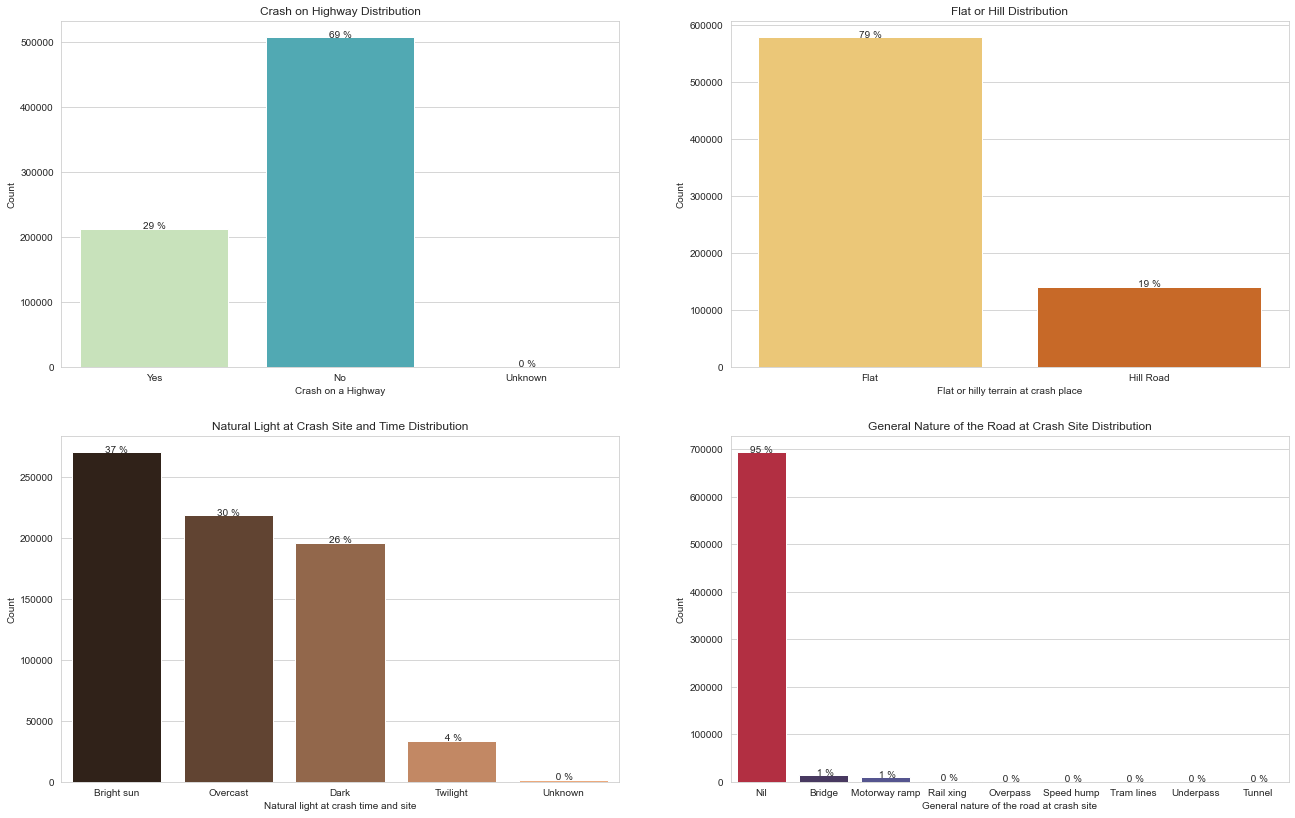

In [45]:
# Plotting of 'crashSHDescription', 'holiday', 'NumberOf Lanes' and 'directionRoleDescription'.

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(22, 14)

mycount_plot('crashSHDescription', 'Crash on a Highway', 'Count', 'Crash on Highway Distribution', 
             ax1, my_format='round', my_palette='YlGnBu')
mycount_plot('flatHill', 'Flat or hilly terrain at crash place', 'Count', 'Flat or Hill Distribution',
             ax2, my_format='round', my_palette='YlOrBr')
mycount_plot('light', 'Natural light at crash time and site', 'Count', 'Natural Light at Crash Site and Time Distribution',
             ax3, my_format='round', my_palette='copper')
mycount_plot('roadCharacter', 'General nature of the road at crash site', 'Count', 
             'General Nature of the Road at Crash Site Distribution', ax4, my_format='round', 
             my_palette='gist_stern')
plt.show()

#### == Analysis for *'roadLane'* (general nature of the road at the crash site) ==

Calculation of its classes data distribution and the distribution of the *'Null'* samples with respect crash severity

In [46]:
# Calculation of the full distribution of values for 'roadLane'
calc_percentages(crashes_NZ, 'roadLane')

          roadLane    percent
2-way       645114  89.697585
1-way        63419   8.817870
Off road     10435   1.450898
Null           242   0.033648


In [47]:
# Distribution of the corresponding samples(rows) with Null in terms of crash severity
Null_list_roadLane = map_vacios('roadLane', 'Null')

                  roadLane
crashSeverity             
Minor Crash             46
Non-Injury Crash       179
Serious Crash           17


The data shows that most of the crashes (close to 90%) occur on 2-way roads. The feature description indicates that *'Null'* is not one of the possible classes. Looking at the composition of the 242 *'Null'* samples in terms of their crash severity, it shows that there are no *'Fatal Crash'* samples. This suggests that removing the *'Null'* samples from the dataset would not alter its balance. Hence, the samples would be removed from the dataset. A graph of the data is shown further below.

Dropping 242 *'Null'* samples for *'roadLane'*

In [48]:
# Dropping 242 Null samples for 'roadLane'
crashes_NZ.drop(Null_list_roadLane.index, inplace=True)

#### == Analysis for *'roadSurface'* (describes the type of road surface) ==

Calculation of its classes data distribution and the distribution of the *'Null'* and *'End of seal'* samples with respect crash severity

In [49]:
# Calculation of the full distribution of values for 'roadCharacter'
calc_percentages(crashes_NZ, 'roadSurface')

             roadSurface    percent
Sealed            704650  98.008534
Unsealed           14236   1.980060
Null                  52   0.007233
End of seal           30   0.004173


In [50]:
# Distribution of the corresponding samples(rows) with Null in terms of crash severity
Null_list_roadSurface = map_vacios('roadSurface', 'Null')

                  roadSurface
crashSeverity                
Minor Crash                 1
Non-Injury Crash           51


In [51]:
# Distribution of the corresponding samples(rows) with 'End of Seal' in terms of crash severity
endseal_list_roadSurface = map_vacios('roadSurface', 'End of seal')

                  roadSurface
crashSeverity                
Minor Crash                 8
Non-Injury Crash           19
Serious Crash               3


The data shows that most of the crashes (close to 98%) occur on sealed roads. The feature description indicates that *'Null'* neither *'End of seal'* are possible classes. Looking at the composition of the 52 *'Null'* and 30 *'End of seal'* samples in terms of their crash severity, it shows that there are no *'Fatal Crash'* samples for any of the two groups. This distribution of the
data shows that removing the *'Null'* and *'End of seal'* samples from the dataset would basically, not alter its balance. Hence, the samples would be removed from the dataset. A graph of the data is shown further below.

Dropping 52 *'Null'* and 30 *'End of seal'* samples for *'roadSurface'*

In [52]:
# Dropping 52 'Null' and 30 'End of seal' samples for 'roadSurface'
crashes_NZ.drop(Null_list_roadSurface.index, inplace=True)
crashes_NZ.drop(endseal_list_roadSurface.index, inplace=True)

#### Analysis for *'streetLight'* (indicates the status of street lighting at time and site of the crash)

Calculation of its classes data distribution

In [53]:
# Calculation of the full distribution of values for 'streetLight'
calc_percentages(crashes_NZ, 'streetLight')

      streetLight    percent
Null       289461  40.265216
Off        175750  24.447548
On         154047  21.428571
None        99628  13.858665


The distribution indicates that most of the data is of class *'Null'* and the feature description shows that there is not such a class, but there is an 'Unknown' one. It is assumed that for this case both of them are equivalent and refer to unknown. Hence, the *'Null'* samples will be renamed to *'Unknown'*. It is important to note that these values are the majority of samples for this feature, which might indicate poor collection of data. Additionally, there is a *'None'* set of values and this is a valid class for this feature, so this data stands as it is. A graph of the data is shown further below.

Renaming the *'Null'* values as *'Unknown'*

In [54]:
# Renaming the 'Null' values as 'Unknown'
replacement = {'Null': 'Unknown'}
crashes_NZ['streetLight'].replace(replacement, inplace=True)

#### == Analysis for *'trafficControl'* (traffic control signals at the crash site) ==

Calculation of its classes data distribution

In [55]:
# Calculation of the full distribution of values for 'trafficControl'
calc_percentages(crashes_NZ, 'trafficControl')

                                               trafficControl    percent
Nil                                                    294516  40.968387
Unknown                                                181174  25.202049
Give way                                               127056  17.674012
Traffic Signals                                         71994  10.014662
Stop                                                    43693   6.077876
School Patrol/warden                                      323   0.044931
Pointsman                                                 104   0.014467
Isolated Pedestrian signal (non-intersection)              26   0.003617


In [56]:
# Reducing the length of some of the class labels, to make it easier to fit in the plot axis
replacement = {'School Patrol/warden': 'School Patrol',
               'Isolated Pedestrian signal (non-intersection)': 'Pedestrian Signal'}
crashes_NZ['trafficControl'].replace(replacement, inplace=True)

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plots below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

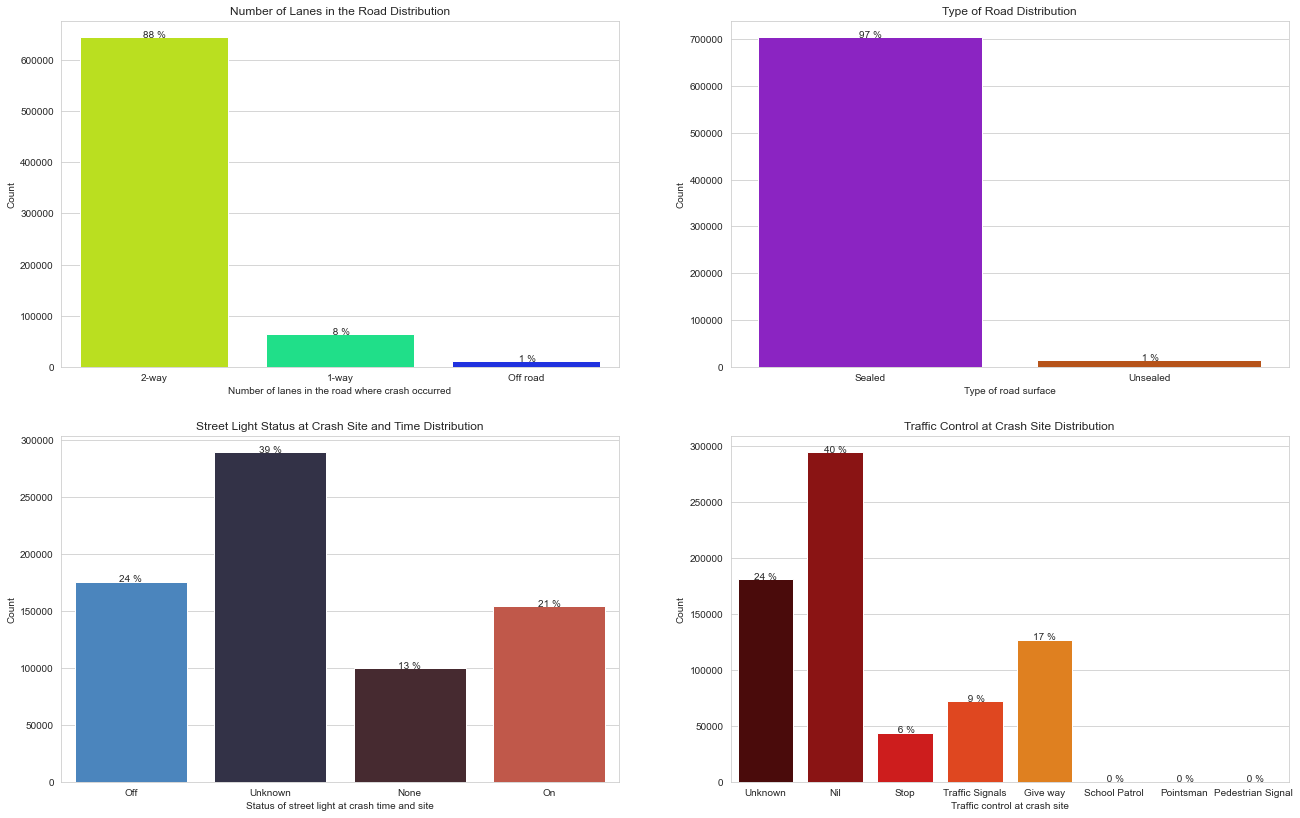

In [57]:
# Plotting of 'roadLane', 'roadSurface', 'streetLight' and 'trafficControl'.

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(22, 14)

mycount_plot('roadLane', 'Number of lanes in the road where crash occurred', 'Count', 'Number of Lanes in the Road Distribution', ax1,
             my_format='round', my_palette='gist_rainbow')
mycount_plot('roadSurface', 'Type of road surface', 'Count', 'Type of Road Distribution', ax2,
             my_format='round', my_palette='gnuplot')
mycount_plot('streetLight', 'Status of street light at crash time and site', 'Count',
             'Street Light Status at Crash Site and Time Distribution', ax3, my_format='round', my_palette='icefire')
mycount_plot('trafficControl', 'Traffic control at crash site', 'Count', 
             'Traffic Control at Crash Site Distribution', ax4, my_format='round', my_palette='hot')
plt.show()

#### == Analysis for *'urban'* (derived feature showing general location of crash site) ==

Calculation of its classes data distribution

In [58]:
# Calculation of the full distribution of values for 'urban'
calc_percentages(crashes_NZ, 'urban')

        urban    percent
Urban  486482  67.671648
Open   232404  32.328352


The distribution indicates that most of the crashes occur in urban areas, with more than twice the number than in the open road. A graph of the data is shown further below.

####  == Analysis for *'weatherA'* (first field to indicate the weather at the crash time and site) ==

Calculation of its classes data distribution and the distribution of the 'NaN' samples with respect crash severity

In [59]:
# Calculation of the full distribution of values for 'weatherA'
calc_percentages(crashes_NZ, 'weatherA')

               weatherA    percent
Fine             559993  77.897330
Light rain       109796  15.273075
Heavy rain        29780   4.142521
Mist or Fog        9708   1.350423
Null               8113   1.128552
Snow               1460   0.203092
Hail or Sleet        36   0.005008


The distribution indicates that most of the crashes occur during fine weather, follow by rainy weather. The distribution shows a class *'Null'*, the feature description does not have a *'Null'* class, instead an *'Unknown'* class. Most probably the two classes refer to the same type of data. Hence, the *'Null'* values will be renamed *'Unknown'*. A graph of the data is shown further below.

Renaming *'Null'* values to *'Unknown'*

In [60]:
# Renaming the 'Null' values as 'Unknown'
replacement = {'Null': 'Unknown'}
crashes_NZ['weatherA'].replace(replacement, inplace=True)

#### == Analysis for *'weatherB'* (second field to indicate the weather at the crash time and site) ==
Calculation of its classes data distribution and the distribution of the 'NaN' samples with respect crash severity

In [61]:
# Calculation of the full distribution of values for 'weatherB'
calc_percentages(crashes_NZ, 'weatherB')

             weatherB    percent
Null           699312  97.277176
Strong wind     11886   1.653391
Frost            7687   1.069293
None                1   0.000139


The distribution indicates that most of the crashes are recorded under the class *'Null'*. As per the previous weather feature, the distribution shows a class *'Null'*, but the feature description does not have a *'Null'* class, instead an *'Unknown'* class. As before, it is safe to assume that the two classes refer to the same type of data. Hence, the *'Null'* values will be renamed *'Unknown'*. Additionally, there is one sample under the class *'None'*, this will be added to the *'Unknown'* class. A graph of the data is shown below.

Renaming the *'Null'* and *'None'* values as *'Unknown'*

In [62]:
# Renaming the 'Null' and 'None' values as 'Unknown'
replacement = {'Null': 'Unknown', 'None': 'Unknown'}
crashes_NZ['weatherB'].replace(replacement, inplace=True)

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>Percentages in the plots below are calculated with respect to the total number of samples (including NaN)</blockquote>
</div>

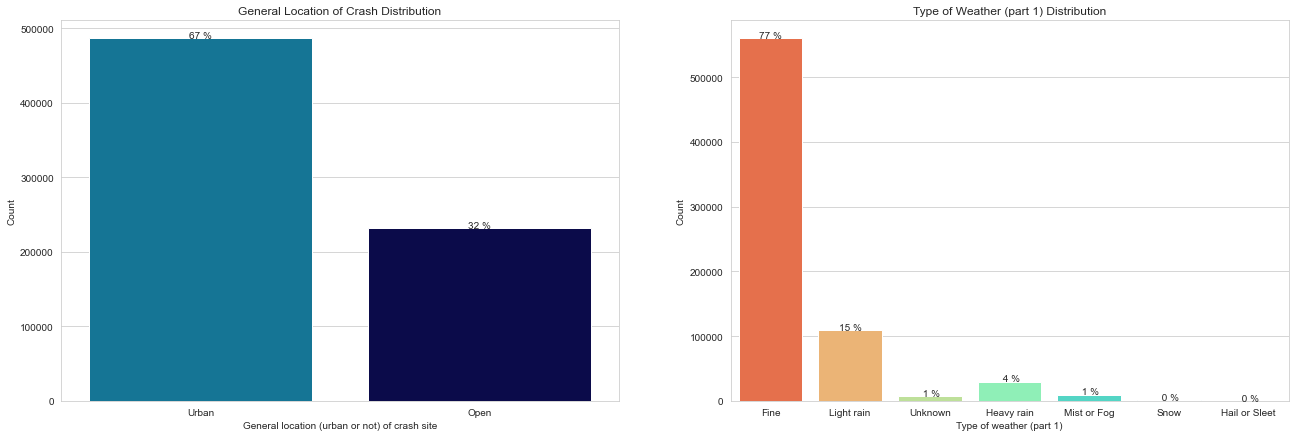

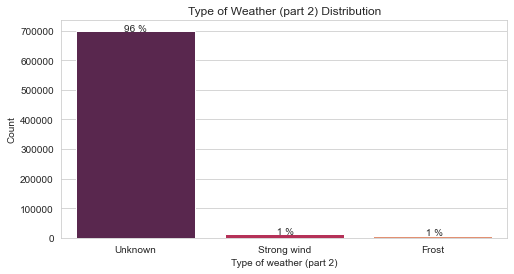

In [63]:
# Plotting of 'urban', 'weatherA' and 'weatherB'.

fig, ((ax1,ax2)) = plt.subplots(1, 2)
fig.set_size_inches(22, 7)

mycount_plot('urban', 'General location (urban or not) of crash site', 'Count', 'General Location of Crash Distribution', ax1,
             my_format='round', my_palette='ocean_r')
mycount_plot('weatherA', 'Type of weather (part 1)', 'Count', 'Type of Weather (part 1) Distribution', ax2,
             my_format='round', my_palette='rainbow_r')
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
mycount_plot('weatherB', 'Type of weather (part 2)', 'Count', 'Type of Weather (part 2) Distribution', ax,
             my_format='round', my_palette='rocket')
plt.show()

## Data Wrangling - Converting Data to Correct Type

All numerical features are of type float but they represent integer values. Therefore, these numerical features are better represented as integer types. Converting all numerical data to integers.

In [64]:
# Convert data types to proper type
# Most of numerical features should be integer instead of float as they are basically counters
count_type = ['bicycle','bridge','bus','carStationWagon','cliffBank','debris','ditch','fence',
            'guardRail','houseOrBuilding','kerb','moped','motorcycle','objectThrownOrDropped',
            'otherObject','otherVehicleType','overBank','parkedVehicle','pedestrian','phoneBoxEtc',
            'postOrPole','roadworks','schoolBus','slipOrFlood','strayAnimal','suv','taxi',
            'trafficIsland','trafficSign','train','tree','truck','unknownVehicleType',
            'vanOrUtility','vehicle','waterRiver']
crashes_NZ[count_type] = crashes_NZ[count_type].astype("int")

new_crashes_NZ = crashes_NZ.copy()

The categorical features are converted to category type

In [65]:
# Change the categorical features from object to category
categ_type = ['crashSeverity', 'crashSHDescription', 'directionRoleDescription', 'flatHill',
              'holiday', 'light', 'NumberOfLanes', 'roadCharacter', 'roadLane', 'roadSurface',
              'speedLimit', 'streetLight', 'tlaName', 'trafficControl', 'urban', 'weatherA',
              'weatherB']
crashes_NZ[categ_type] = crashes_NZ[categ_type].astype("category")

# Looking at the dataset info
crashes_NZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718886 entries, 0 to 725547
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   bicycle                   718886 non-null  int64   
 1   bridge                    718886 non-null  int64   
 2   bus                       718886 non-null  int64   
 3   carStationWagon           718886 non-null  int64   
 4   cliffBank                 718886 non-null  int64   
 5   crashSeverity             718886 non-null  category
 6   crashSHDescription        718886 non-null  category
 7   debris                    718886 non-null  int64   
 8   directionRoleDescription  718886 non-null  category
 9   ditch                     718886 non-null  int64   
 10  fence                     718886 non-null  int64   
 11  flatHill                  718886 non-null  category
 12  guardRail                 718886 non-null  int64   
 13  holiday                   718

### Data Wrangling - Summary

After examining and modifing the dataset, it is now reduced by 6662 samples and 19 features. Therefore, the new size of the dataset is 718886 samples and 53 features. Additionally, all samples with *'NaN'* values that were not removed from the dataset, were replaced with appropriated values. Similarly, other values such as *'Null'* have been dealt with. 

The removal of the 6662 samples was done keeping in mind that there are few total *'Fatal Crash'* samples in the dataset and it was important to remove as few as possible. To accomplish this the distribution of the candidate samples for removal with respect to *'CrashSeverity'* was used to evaluate the impact. Out of the 6662 samples removed only 13 corresponded to *'Fatal Crash'* samples.

In [66]:
print('\n', 'The new dataset has ', crashes_NZ.shape[0], 'samples and ', crashes_NZ.shape[1],
      'features','\n')


 The new dataset has  718886 samples and  53 features 



## Data Exploration - Features Correlation

#### == Visual exploration ==

To analyse the relationships among the categorical features, a series of plots present the distribution of the features different classes into the classes of the target feature, *'crashSeverity'*.

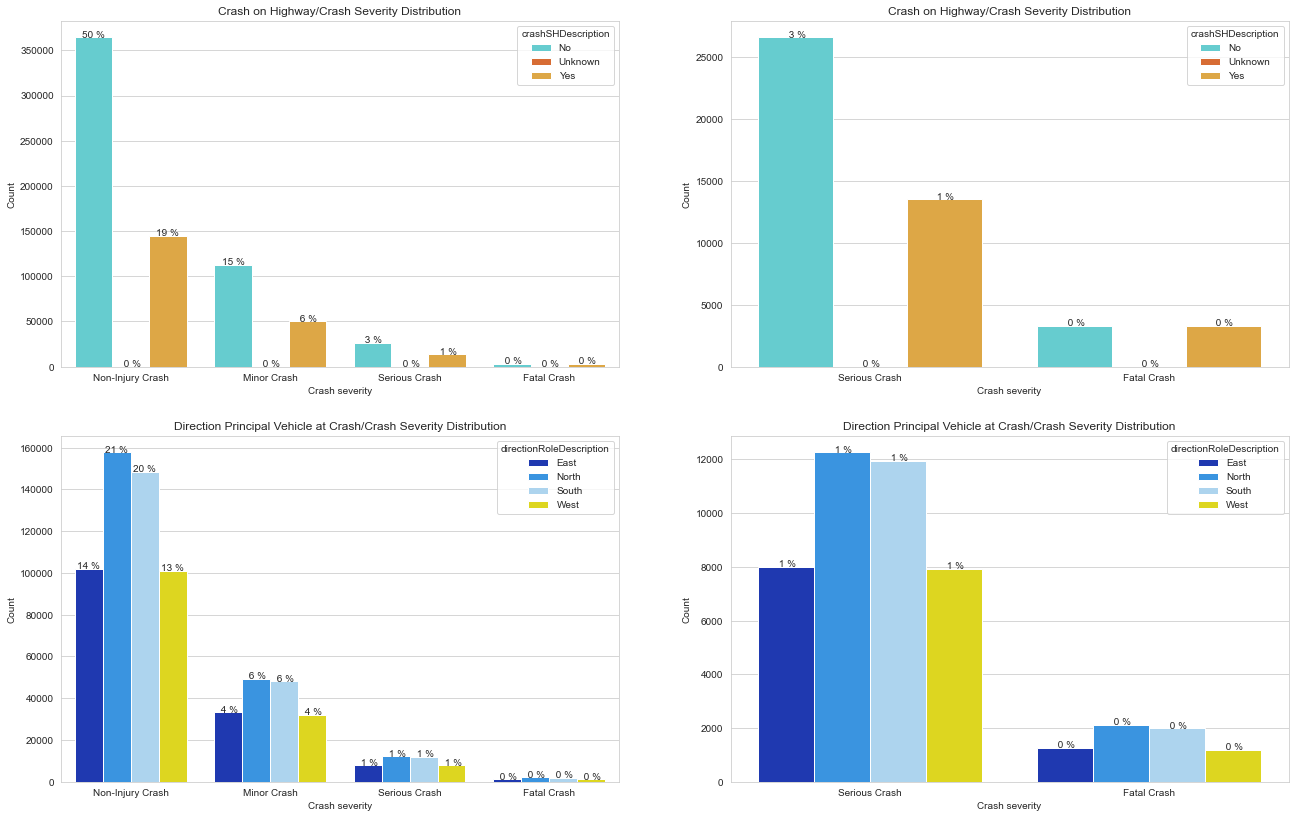

In [67]:
# Plotting the relationship of 'crashSHDescription' and 'directionRoleDescription' with 'crashSeverity'
# For each feature there is an additional close-view of the plots

# Initial plot settings
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(22, 14)

# Definition of some new palettes
my_colors1 = ['#55DDE0', '#F26419', '#F6AE2D', '#2F4858', '#33658A']
my_colors2 = ['#072AC8', '#1E96FC', '#A2D6F9', '#FCF300', '#FFC600']

# List of the classes used for the close-view plots
zoom_order = ['Serious Crash', 'Fatal Crash']

# PLotting for 'crashDescription'  - complete and close-view
mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Crash on Highway/Crash Severity Distribution',
             my_order=plot_order, my_hue="crashSHDescription", my_ax=ax1, my_format='round', 
             my_palette=my_colors1)
mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Crash on Highway/Crash Severity Distribution',
             my_order=zoom_order, my_hue='crashSHDescription', my_ax=ax2, my_format='round',
             my_palette=my_colors1)

# PLotting for 'directionRoleDescription'  - complete and close-view
mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Direction Principal Vehicle at Crash/Crash Severity Distribution', 
             my_order=plot_order, my_hue='directionRoleDescription', my_ax=ax3, my_format='round',
             my_palette=my_colors2)
mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Direction Principal Vehicle at Crash/Crash Severity Distribution', 
             my_order=zoom_order, my_hue='directionRoleDescription', my_ax=ax4, my_format='round',
             my_palette=my_colors2)
plt.show()

This set of plots show the full plot on the left and a zoom of the distributions for *'Serious Crash'* and *'Fatal Crash'* on the right. Both features show expected distributions in terms of few samples for *'Fatal Crash'* and more or less even values across the feature classes. It is difficult to extract any conclusion about the relationship among the features and the target.

Plots of the other categorical features

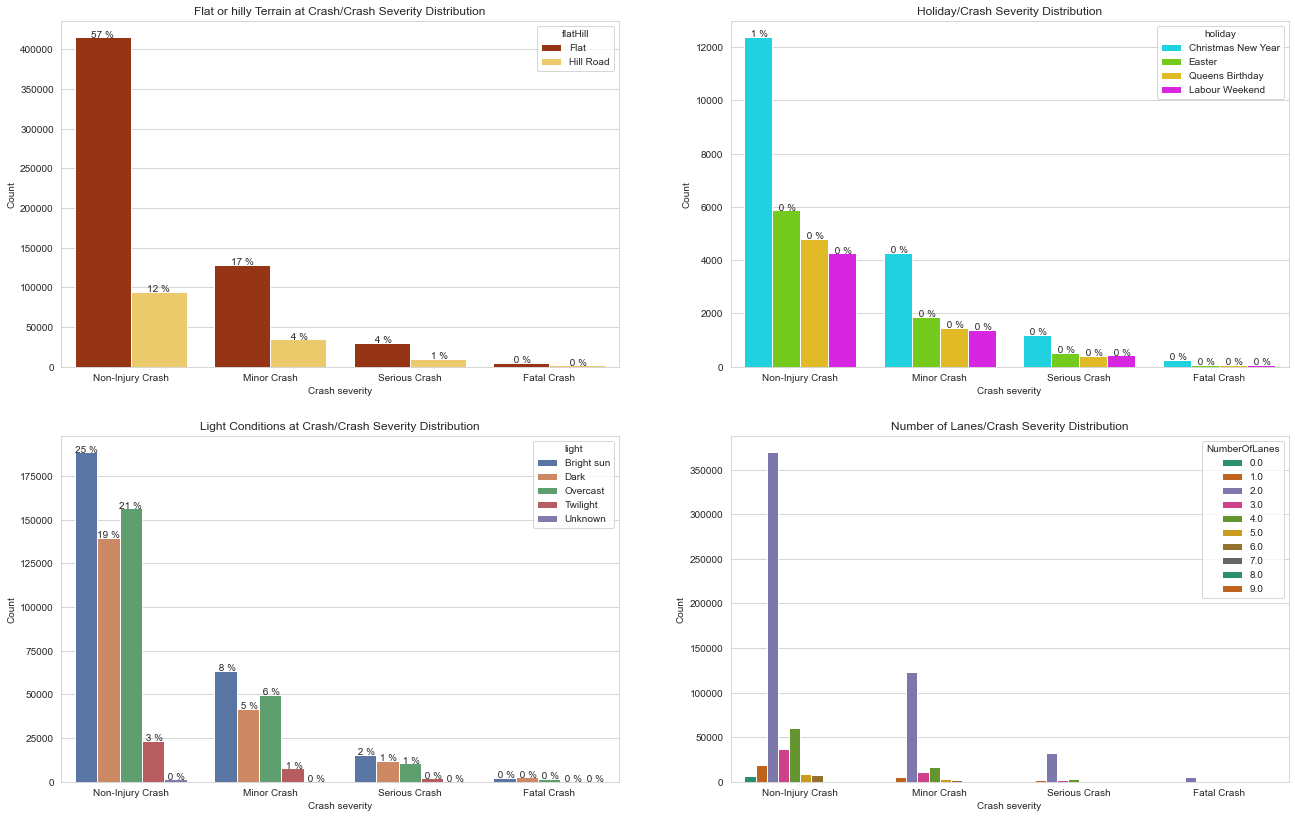

In [68]:
# Plotting of the relationship of 'flatHill', 'holiday' , 'light' and 'NumberOfLanes' features
# with 'crashSeverity'

# Initial plot settings
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(22, 14)

# Some new colors

plot_hue_order = ['Christmas New Year', 'Easter', 'Queens Birthday', 'Labour Weekend']


mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Flat or hilly Terrain at Crash/Crash Severity Distribution', 
            my_order=plot_order, my_hue='flatHill', my_ax=ax1, my_format='round',
            my_palette='afmhot')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Holiday/Crash Severity Distribution', 
             my_order=plot_order, my_hue='holiday', my_hue_order=plot_hue_order, my_ax=ax2,
             my_format='round', my_palette='gist_ncar')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Light Conditions at Crash/Crash Severity Distribution', 
            my_order=plot_order, my_hue='light', my_ax=ax3, my_format='round',
            my_palette='deep')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Number of Lanes/Crash Severity Distribution', 
             my_order=plot_order, my_hue='NumberOfLanes', my_ax=ax4,
             my_format='None', my_palette='Dark2')


plt.show()

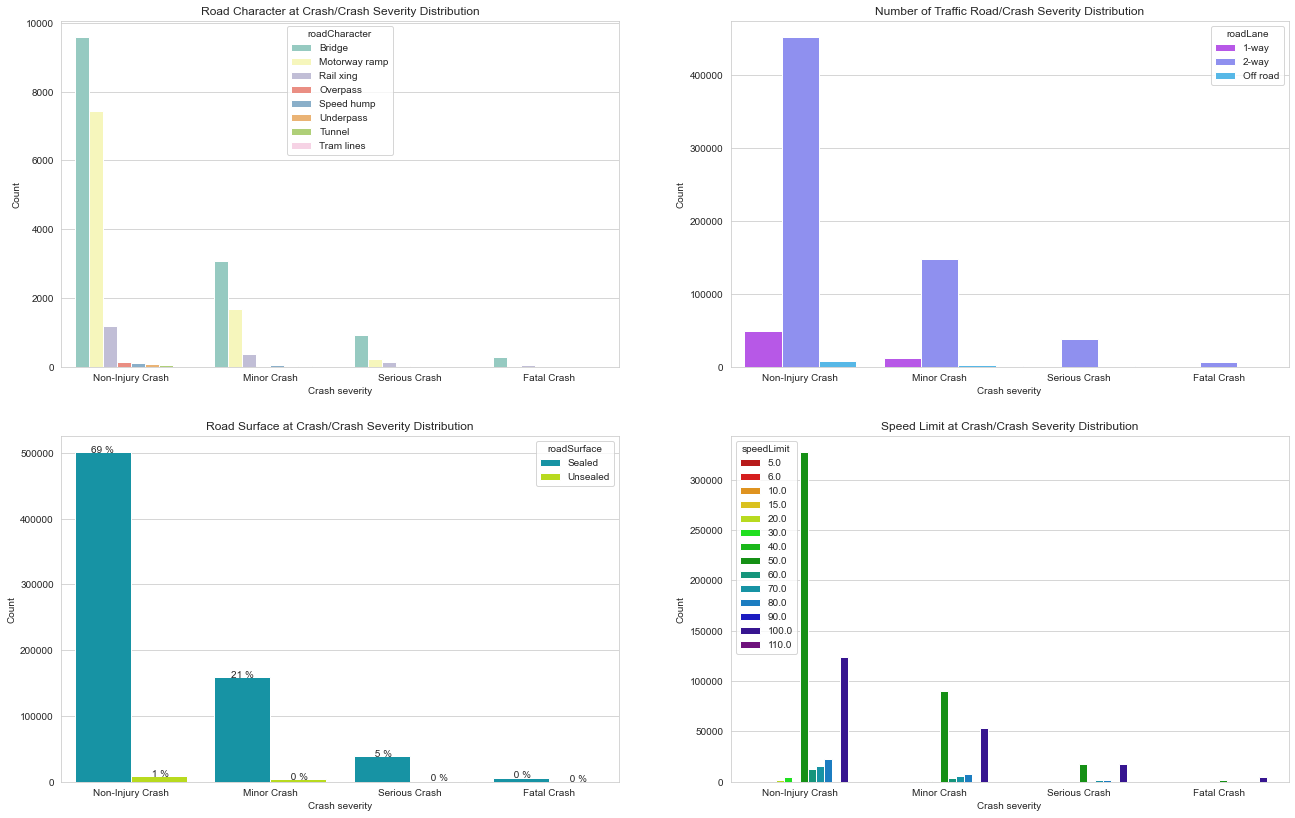

In [69]:
# Plotting of the relationship of 'roadCharacter', 'roadLane', 'roadSurface', and 'speedLimit' features
# with 'crashSeverity'

# Initial plot settings
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(22, 14)

# Some new colors

plot_hue_order = ['Bridge', 'Motorway ramp', 'Rail xing', 'Overpass', 'Speed hump',
                  'Underpass', 'Tunnel', 'Tram lines']


mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Road Character at Crash/Crash Severity Distribution', 
            my_order=plot_order, my_hue='roadCharacter', my_hue_order=plot_hue_order,
            my_ax=ax1, my_format='None', my_palette='Set3')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Number of Traffic Road/Crash Severity Distribution', 
             my_order=plot_order, my_hue='roadLane', my_ax=ax2,
             my_format='None', my_palette='cool_r')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Road Surface at Crash/Crash Severity Distribution', 
            my_order=plot_order, my_hue='roadSurface', my_ax=ax3, my_format='round',
            my_palette='nipy_spectral')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Speed Limit at Crash/Crash Severity Distribution', 
             my_order=plot_order, my_hue='speedLimit', my_ax=ax4,
             my_format='None', my_palette='nipy_spectral_r')


plt.show()

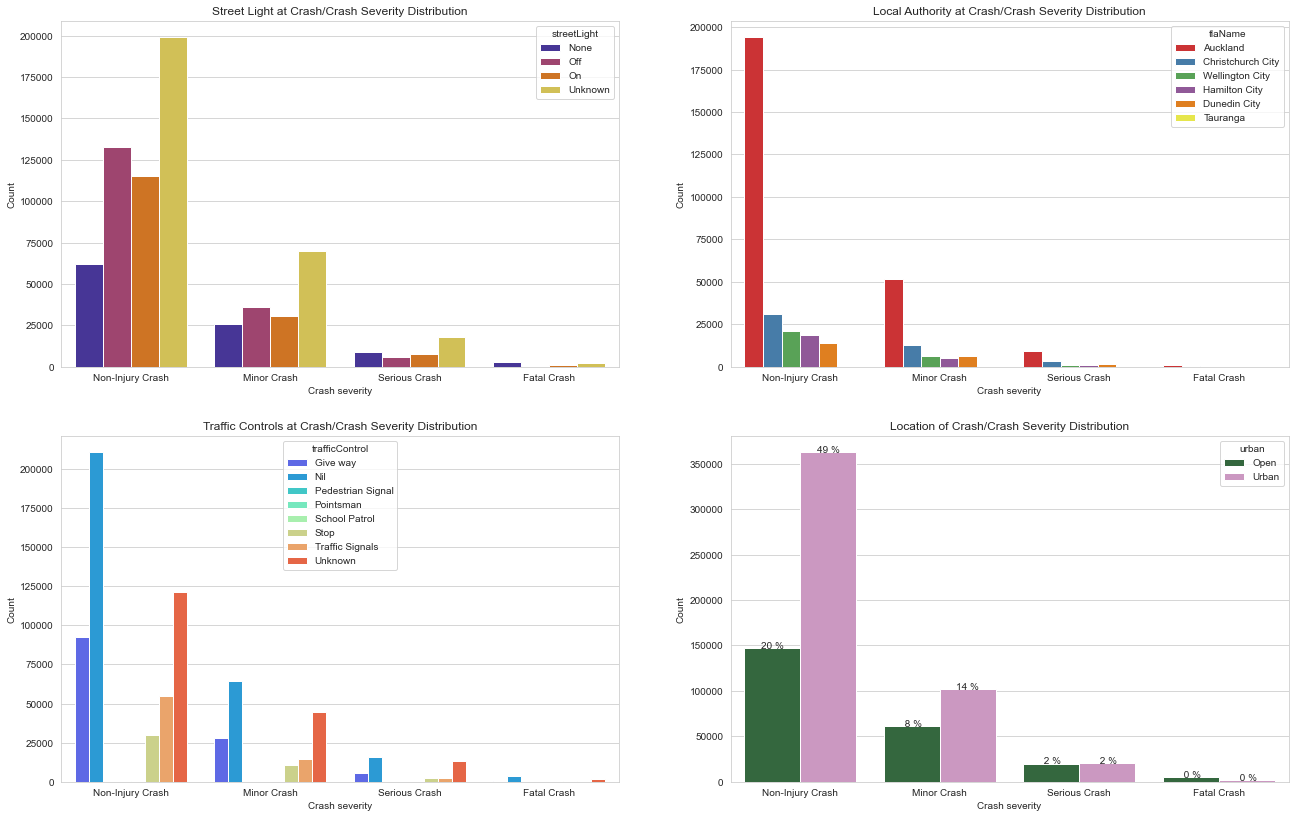

In [70]:
# Plotting of the relationship of 'streetLight', 'tlaName', 'trafficControl', and 'urban' features
# with 'crashSeverity'

# Initial plot settings
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(22, 14)

# Some new colors
my_colors3 = ['#78C850', '#F08030', '#6890F0', '#A8B820', '#A8A878', '#A040A0']


mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Street Light at Crash/Crash Severity Distribution', 
            my_order=plot_order, my_hue='streetLight',
            my_ax=ax1, my_format='None', my_palette='CMRmap')


cities = ['Auckland', 'Christchurch City', 'Wellington City', 'Hamilton City',
         'Dunedin City', 'Tauranga']


mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Local Authority at Crash/Crash Severity Distribution', 
             my_order=plot_order, my_hue='tlaName', my_hue_order=cities, my_ax=ax2,
             my_format='None', my_palette='Set1')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Traffic Controls at Crash/Crash Severity Distribution', 
            my_order=plot_order, my_hue='trafficControl', my_ax=ax3, my_format='None',
            my_palette='rainbow')

mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Location of Crash/Crash Severity Distribution', 
             my_order=plot_order, my_hue='urban', my_ax=ax4,
             my_format='round', my_palette='cubehelix')


plt.show()

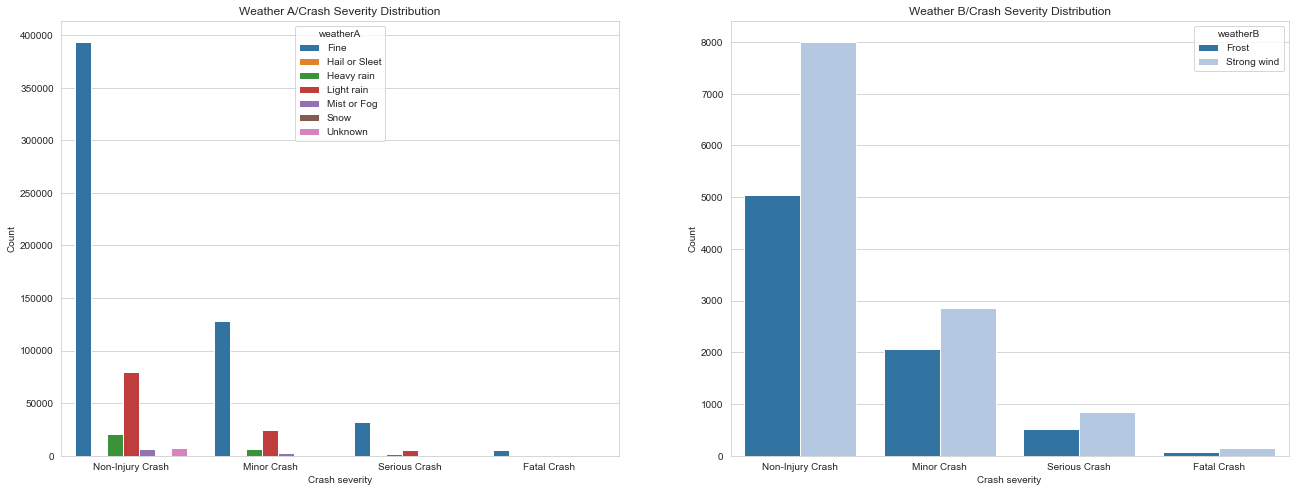

In [71]:
# Plotting of the relationship of 'weatherA' and 'weatherB' features with 'crashSeverity'

# Initial plot settings
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(22, 8)



mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Weather A/Crash Severity Distribution', 
            my_order=plot_order, my_hue='weatherA',
            my_ax=ax1, my_format='None', my_palette='tab10')

plot_hue_order = ['Frost', 'Strong wind']


mycount_plot('crashSeverity', 'Crash severity', 'Count', 'Weather B/Crash Severity Distribution', 
             my_order=plot_order, my_hue='weatherB', my_hue_order=plot_hue_order, my_ax=ax2,
             my_format='None', my_palette='tab20')

plt.show()

All the plots show a similar behaviour, with very few samples on the *'Serious Crash'* and the *'Fatal Crash'* classes and presenting a similar proportionality across the classes. From the plots is not possible to identify features that could have strong relationships to the target feature. 

#### == Correlation analysis ==

Another way to explore the relationships among the features is to analyse their correlation matrix.
The chi-square can be used to analyse systems that have only categorical features.

After doing some literature research it was possible to identify two new methodologies that are able to manage systems with categorical and numerical features. These two methods are:

- Phi_K a new and practical correlation coefficient based on several refinements to Pearson’s hypothesis test of independence of two variables. The combined features of Phi_K form an advantage over existing coefficients. First, it works consistently between categorical, ordinal and interval variables. Second, it captures non-linear dependency. Third, it reverts to the Pearson correlation coefficient in case of a bi-variate normal input distribution. These are useful features when studying the correlation matrix of variables with mixed types. The methodology is available as a Python package and can be easily installed. For additional information: 

    Package website: [Phi_K Correlation Analyser Library](https://phik.readthedocs.io/en/latest/index.htm) 
    
    Technical paper: [A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics](https://arxiv.org/abs/1811.11440). M. Baak, R. Koopman, H. Snoek, S. Klous. Computational Statistics and Data analysis. March 2019.

- Dython another new methodology calculates the correlation/strength-of-association of features in data-set with both categorical and continuous features using: * Pearson's R for continuous-continuous cases * Correlation Ratio for categorical-continuous cases * Cramer's V or Theil's U for categorical-categorical cases. The methodology is available as a Python package and can be easily installed. For additional information:

    Package website: [Dython](http://shakedzy.xyz/dython/)
    
    Technical paper:[The Search for Categorical Correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9). Shaked Zychlinski. Towards Data Science. Feb. 2018


#### == Correlation of categorical features ==

Initially looking at only the categorical features to explore the two proposed methodologies

Use a smaller dataframe with only the categorical features

In [72]:
# Construction of a dataframe with only category type features
crashes_NZ_catg = crashes_NZ.select_dtypes(include='category')
crashes_NZ_catg.shape

(718886, 17)

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>The calculation of the correlation matrices takes some time. If you want you can skip the next cells and read the conclusions of this analysis. Otherwise, please relax and wait for the calculations.</blockquote>
</div>

##### ==== Using Phi_K package ====

Calculation of the Phi_K correlation matrix and plot of the results for categorical features. (Values are between 0 and 1, with 0 indicating no correlation and 1 strong correlation)

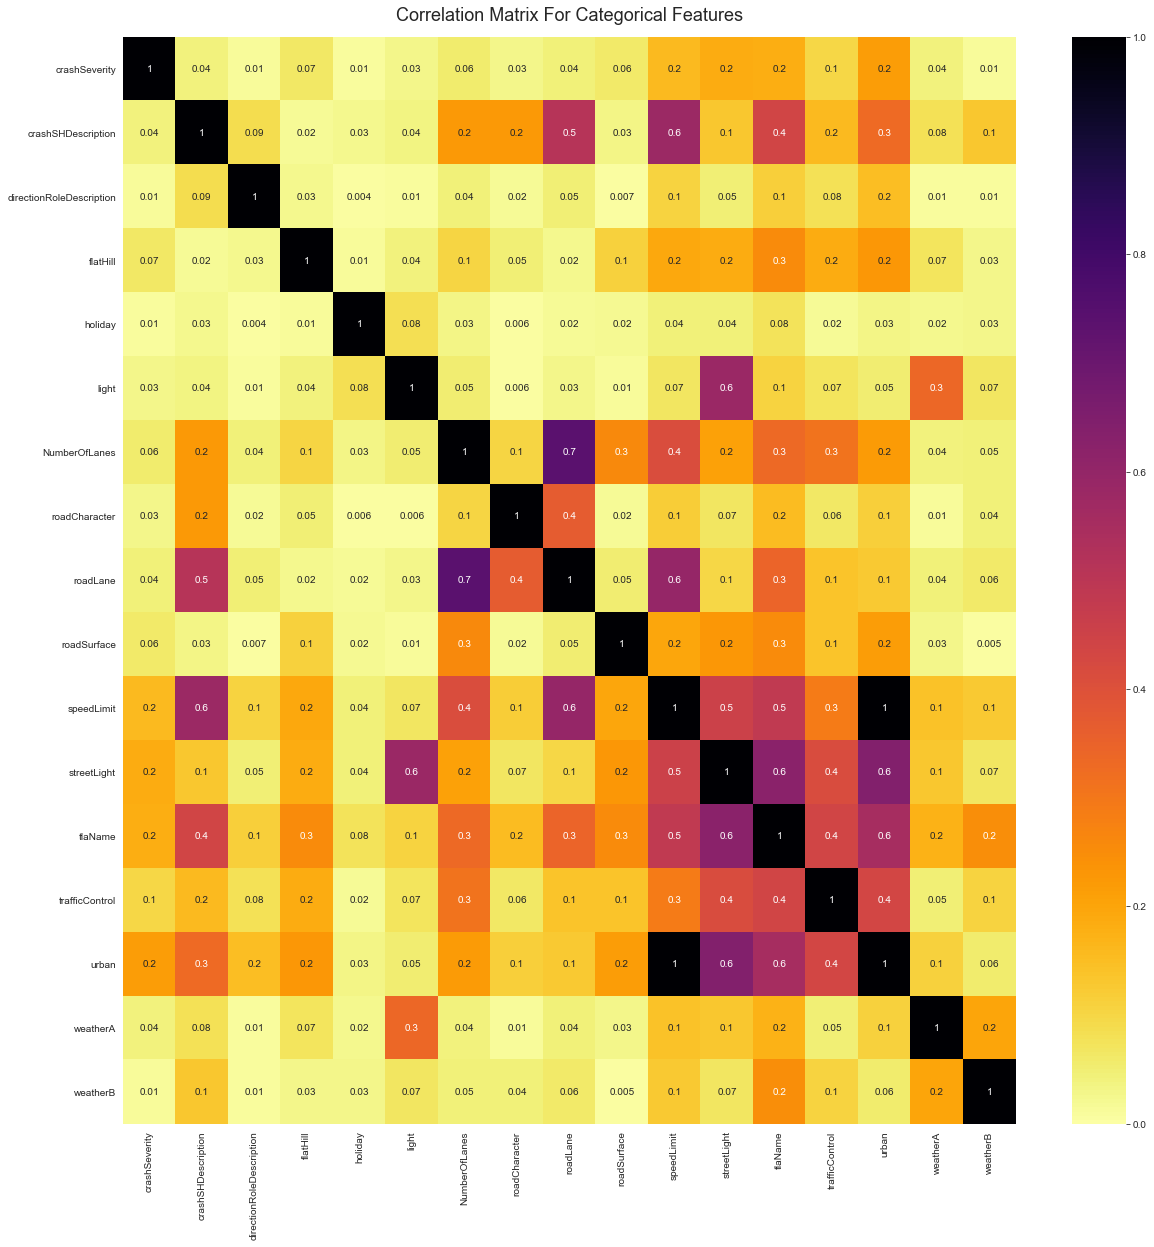

In [73]:
# Using the Phi_K package - correlation matrix
plt.figure(figsize=(20, 20))
my_heatmap = sns.heatmap(crashes_NZ_catg.phik_matrix(), vmin=0, vmax=1, annot=True, 
                      fmt='.1g', cmap='inferno_r')
my_heatmap.set_title('Correlation Matrix For Categorical Features', fontdict={'fontsize':18}, pad=16)
plt.show()

The matrix supports the findings that were observed with the visual exploration. There are no categorical features with medium/strong correlation to the target feature *'crashSeverity'*.
There are a few ones that show a low level of correlation and that have to be use for the analysis.
They are *'speedLimit'*, *'streetLight'*, *'tlaName'*, *'trafficControl'* and *'urban'*. 

The Phi_K methodology offers the possibility to calculate a significance matrix, which examines the statistical significance of the previous calculated correlations.  

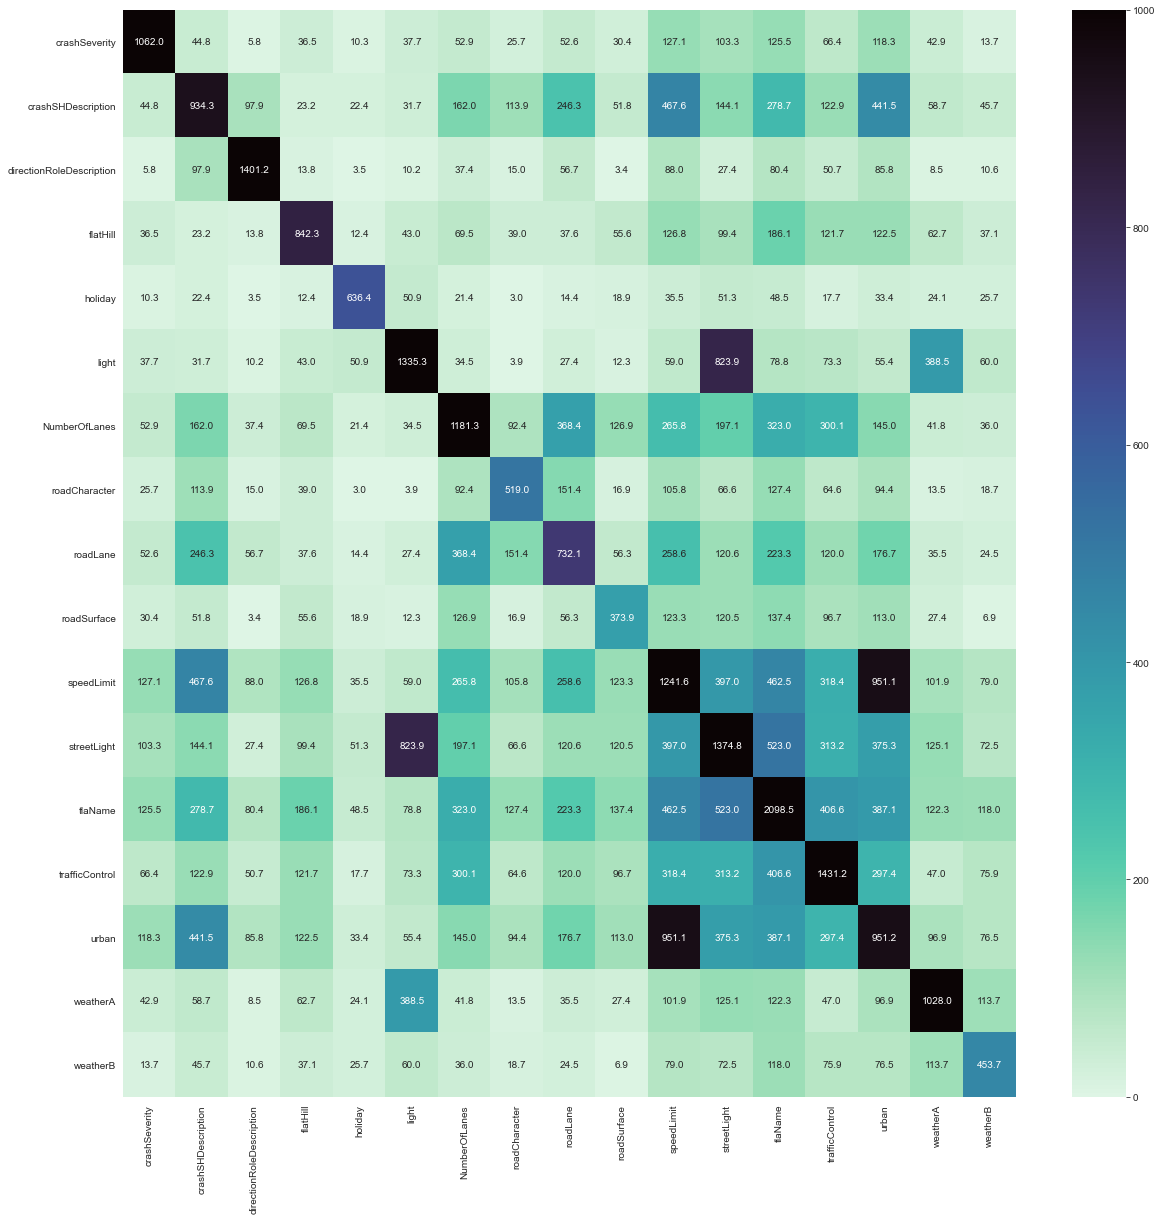

In [74]:
# Calculation of the significance matrix from Phi_K methodology

plt.figure(figsize=(20, 20))
my_heatmap = sns.heatmap(crashes_NZ_catg.significance_matrix(), vmin=0, vmax=1000, annot=True, 
                      fmt='3.1f', cmap='mako_r')
plt.show()

The significance matrix corroborates that the features selected before represent a valid correlation with the target feature.

##### ==== Using Dython package ====

Calculation of the Dython correlation matrix for categorical features

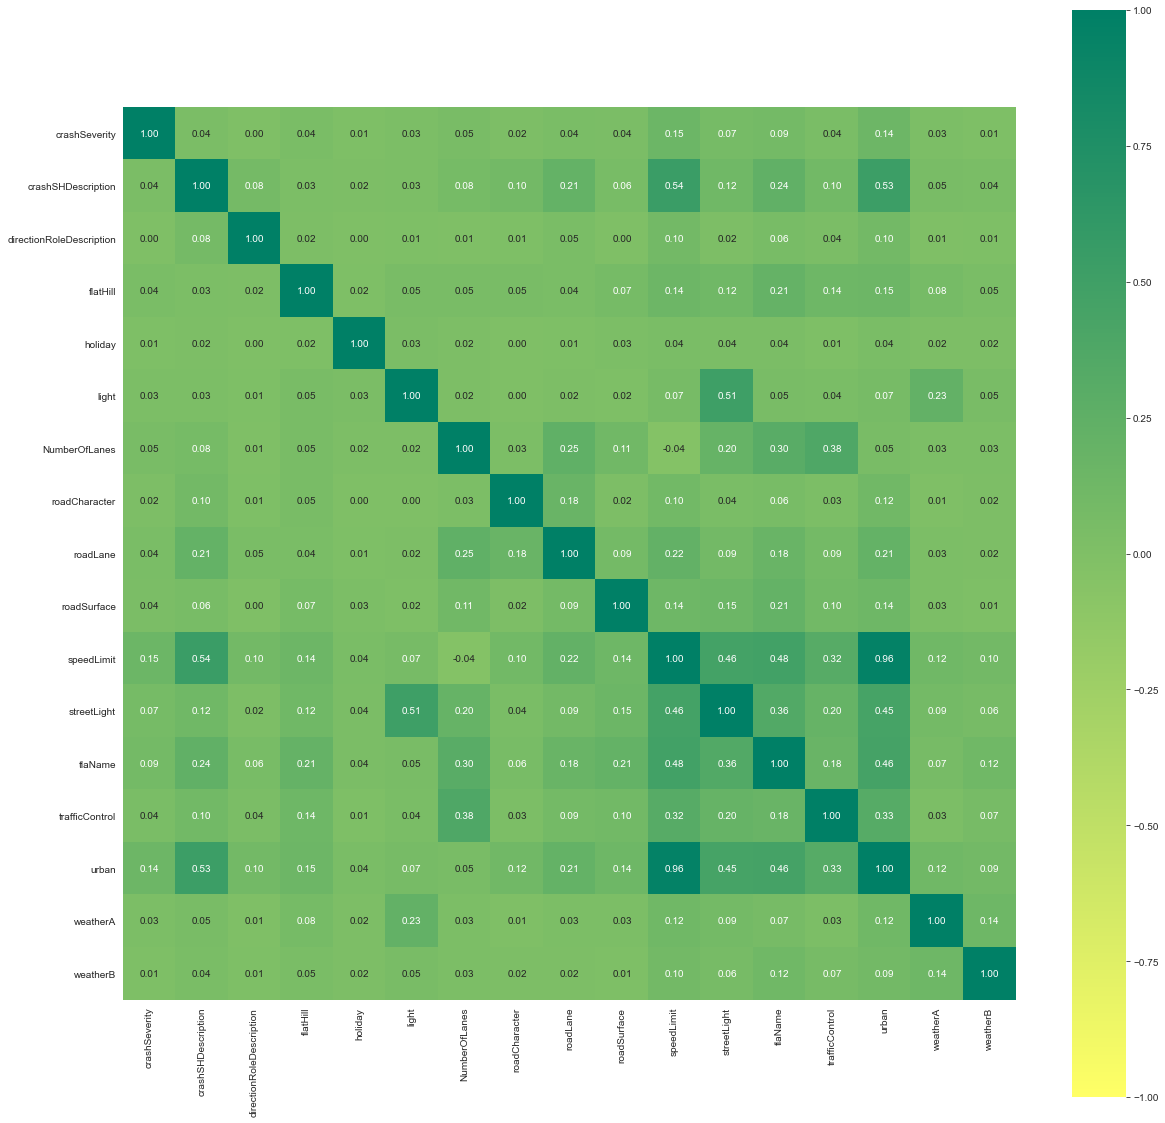

In [75]:
# Modification of the categorical dataframe to be able to use it with Dython package.

crashes_NZ_objt = crashes_NZ_catg.astype('object')
# Calculation of the correlation matrix
correla_dython1 = associations(crashes_NZ_objt, figsize=(20, 20), cmap='summer_r')

It is possible to observe that this methodology cannot detect as many correlations as Phi_K. But allows to corroborate some of the relationships detected before. 

##### ==== Using Chi-square test of independence ====

The Chi-square methodology has been in use for a long time and it is well establish as a way to identify relationships among categorical features.

In [76]:
# Preparing the data - Separate the target feature 'crashSeverity'

X_crashes_Chi = crashes_NZ_catg.drop('crashSeverity',axis=1)
y_crashes_Chi = crashes_NZ_catg['crashSeverity']
X_column_chi_labels = X_crashes_Chi.columns

In [77]:
# Convert categorical values to integers as the Chi test only accepts numerical inputs
# Use the OrdinalEncoder

encoder = ce.OrdinalEncoder(cols=X_column_chi_labels)
encoder.fit(X_crashes_Chi)
# encoded X
X_Chi_enco = encoder.transform(X_crashes_Chi)
encoder = ce.OrdinalEncoder(cols='crashSeverity')
encoder.fit(y_crashes_Chi)
# encoded y
y_Chi_enco = encoder.transform(y_crashes_Chi)

/Users/fercho/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Chi-square test of independence

In [78]:
# Calculating Chi-2 and looking at the p values (if p is very small or zero indicates a relationship)
chi_crashes, p_crashes = chi2(X_Chi_enco, y_Chi_enco)
p_crashes

array([3.12381306e-055, 1.02361169e-002, 2.08343564e-039, 5.60877767e-008,
       4.50553488e-039, 1.04678137e-048, 1.06205056e-003, 1.69101500e-037,
       1.20564885e-004, 0.00000000e+000, 7.07206817e-109, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.00744255e-019, 1.57564464e-002])

The results of the Chi-2 support the selection of features obtained with Phi_K and Dython.

#### == Full matrices ==

The two new methodologies (Phi_K and Dython) are capable of calculating the correlation matrix for combine categorical and numerical features. In the literature covered in the course there was no mention of a similar methodology.

Hence, the two new methodologies will be used for the full set of features.

In [79]:
# Preparing some data
counters = ['bicycle', 'bridge', 'bus', 'carStationWagon', 'cliffBank', 'debris', 'ditch',
             'fence', 'guardRail', 'houseOrBuilding', 'kerb', 'moped', 'motorcycle', 
             'objectThrownOrDropped', 'otherObject', 'otherVehicleType', 'overBank', 
             'parkedVehicle', 'pedestrian', 'phoneBoxEtc', 'postOrPole', 'roadworks', 
             'schoolBus', 'slipOrFlood', 'strayAnimal', 'suv', 'taxi', 'trafficIsland', 
             'trafficSign', 'train', 'tree', 'truck', 'unknownVehicleType', 'vanOrUtility', 
             'vehicle', 'waterRiver']

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>The calculation of these full featured correlation matrices takes several minutes. If you want you can skip the next cells and read the conclusions of this analysis. Otherwise, please relax, get a tea and wait for the calculations.</blockquote>
</div>

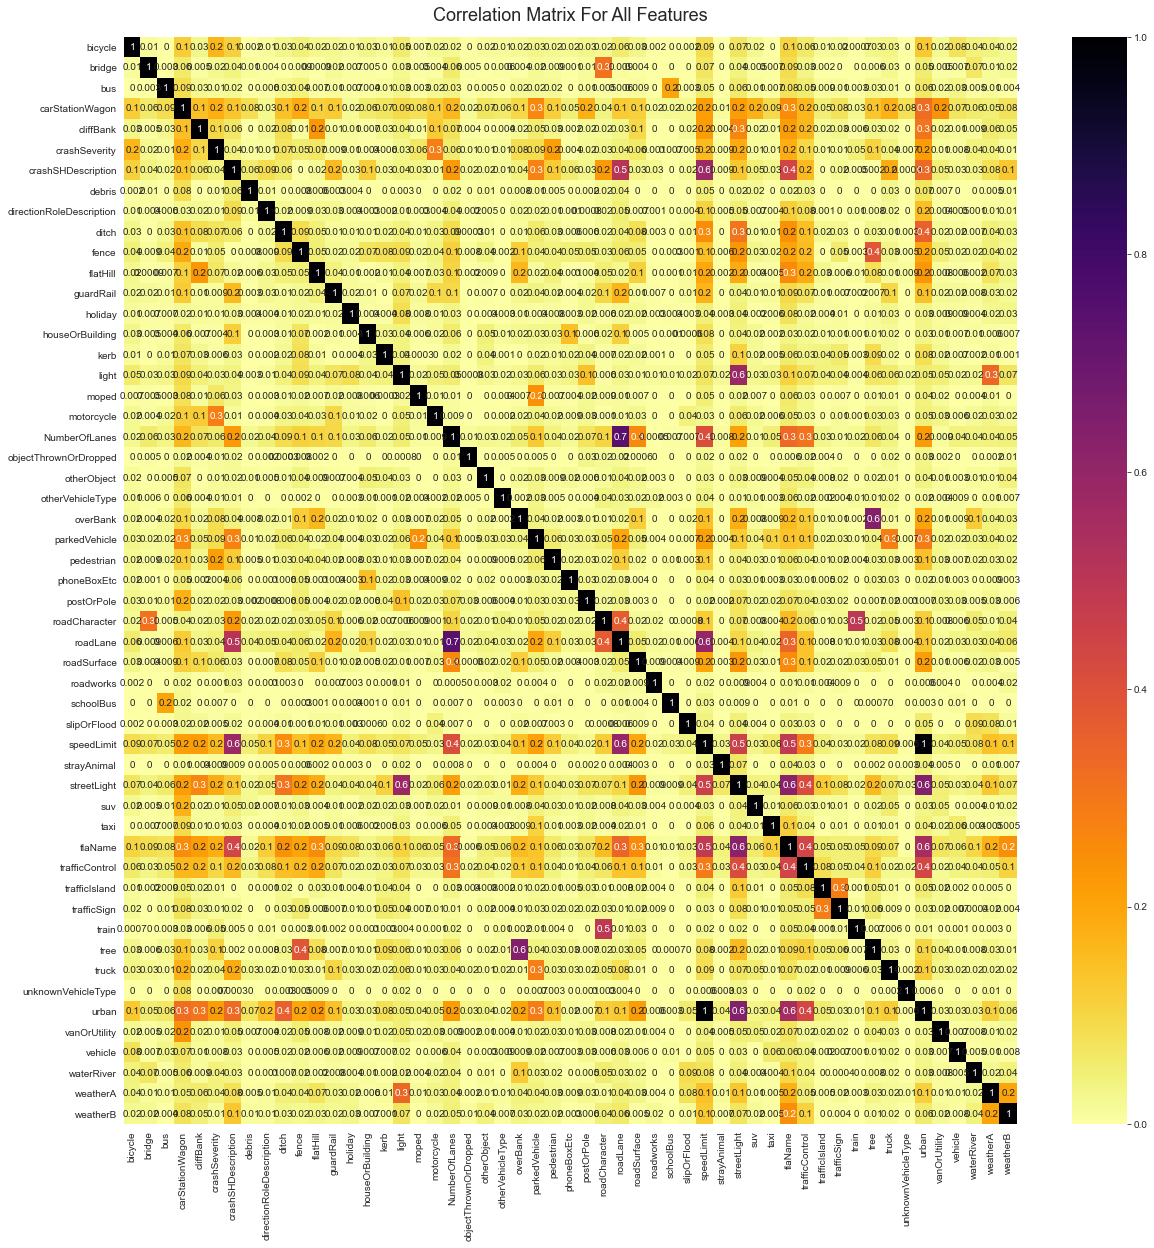

In [80]:
# Using the Phi_K package

plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(crashes_NZ.phik_matrix(interval_cols=counters),vmin=0, vmax=1, annot=True, 
                      fmt='.1g', cmap='inferno_r')
heatmap.set_title('Correlation Matrix For All Features', fontdict={'fontsize':18}, pad=16);

The Phi_K correlation matrix indicates that there are a few features with a small correlation to the target feature *'crashSeverity'*, some of them already determined in our previous categorical analysis. The list is: *'bicycle', 'carStationWagon', 'cliffBank', 'motorcycle', 'pedestrian', 'speedLimit', 'streetLight', 'tlaName', 'trafficControl'  and 'urban'.*

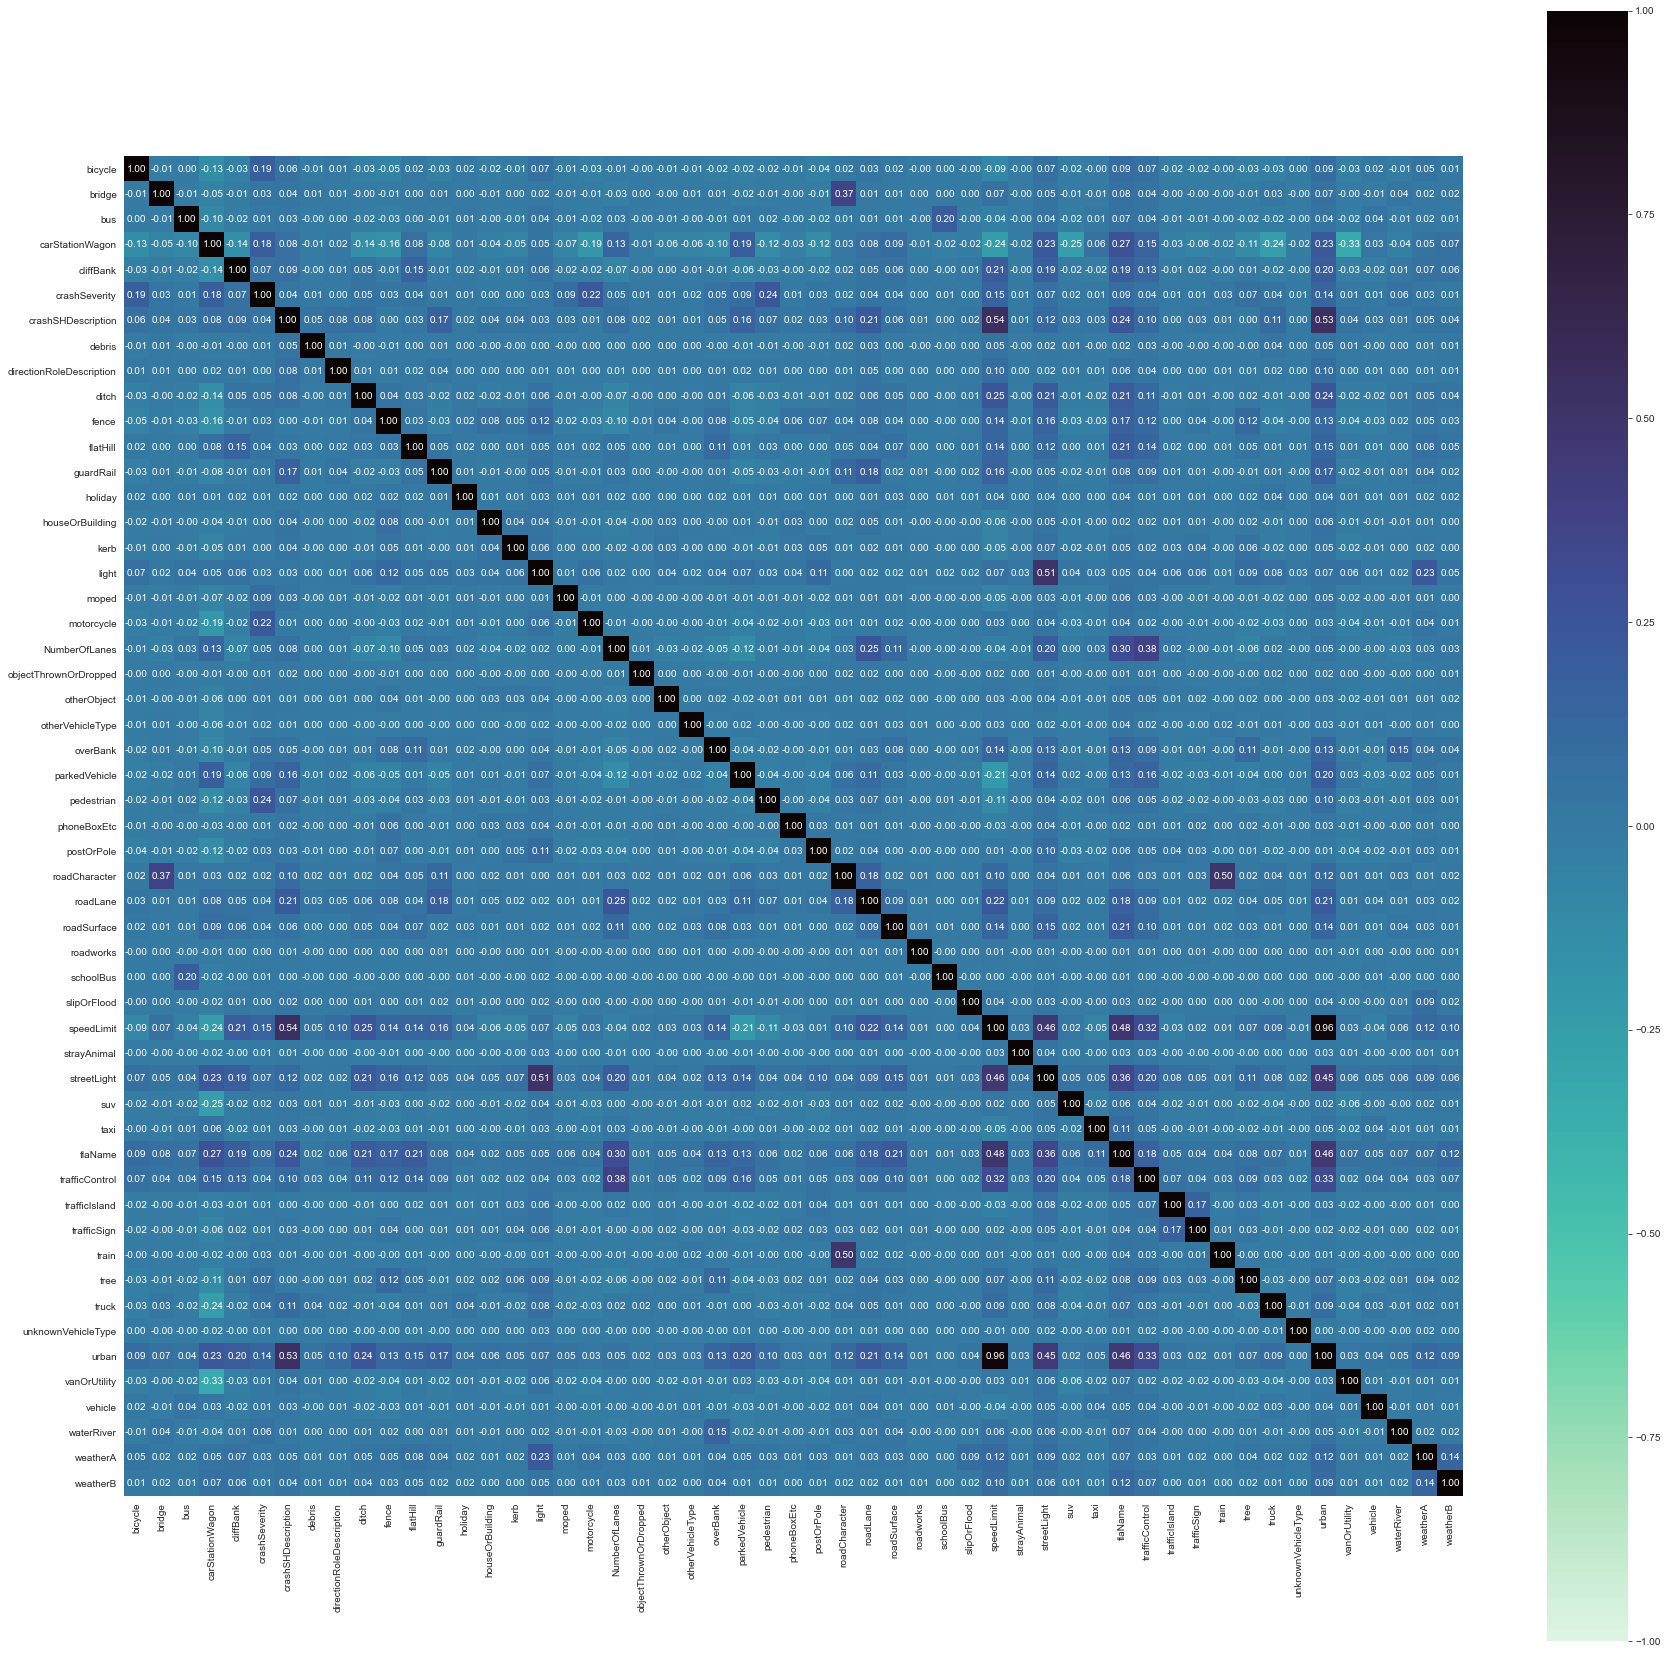

In [81]:
# Using the Dython package

correla_dython2 = associations(new_crashes_NZ, figsize=(30, 30), cmap='mako_r')

The Dython correlation matrix corroborates the list of features detected by Phi_K.

#### == Features selection ==
Based on the analysis presented in the previous sections, it is possible to determine that the visual examination did not show any clear relationships and the correlation matrix shows some few weak relationships with features. This lack of strong relationships between the target feature *'crashSeverity'* and other features could present a problem for classification machines to develop a strong and accurate model of the system.

Following the conclusions of the correlation matrix section the following list of features will be used to continue the analysis. List of selected features: *'bicycle', 'carStationWagon', 'cliffBank', 'motorcycle', 'pedestrian', 'speedLimit', 'streetLight', 'tlaName', 'trafficControl' and 'urban'.*

In [82]:
# Selected features and companion X, y dataframes

selec_features = ['bicycle', 'carStationWagon', 'cliffBank', 'motorcycle', 'pedestrian',
                 'speedLimit', 'streetLight', 'tlaName', 'trafficControl', 'urban']
X_crashes = crashes_NZ.drop('crashSeverity',axis=1)
X_select = X_crashes[selec_features].copy()
y_select = crashes_NZ['crashSeverity'].copy()
X_select_catg = ['speedLimit', 'streetLight', 'tlaName', 'trafficControl', 'urban']

## Imbalanced Dataset - Three Scenarios
The target feature *'crashSeverity'* is highly imbalanced, looking at the distribution of its data after the data exploration and sanitation. 

In [83]:
# Data distribution for the target feature - 'crashSeverity'
print("Number of samples per class for 'crashSeverity'")
y_select.value_counts(dropna=False)

Number of samples per class for 'crashSeverity'


Non-Injury Crash    509326
Minor Crash         162882
Serious Crash        40104
Fatal Crash           6574
Name: crashSeverity, dtype: int64

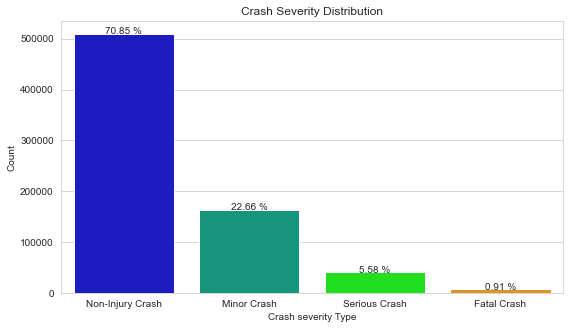

In [84]:
# Plot the count values for crash severity
#
total = float(len(y_select))
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
plot_order = ['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash']
mycount_plot(y_select, 'Crash severity Type', 'Count', 'Crash Severity Distribution', ax,
             my_order=plot_order, my_format='deci')
plt.show()

The graph shows the large imbalanced among the four classes. *'Non-injury Crash'* has close to 71% of the data, while *'Fatal Crash'* barely reaches 0.9%. It is possible to use the data in this form to train and test an modeling algorithm. It might appear that the model is performing correctly during the testing, but it might failed and not generalise during production after is exposed to larger datasets.

There are basically two main ways of "balancing" an imbalanced dataset:
- Under-sampling:  the idea is very simple, just remove samples to bring the class with more counts(majority class) to a level that is more in balance with the class with the less counts(minority class). There are several ways of accomplish this, but the most popular is to remove randomly samples that belong to the majority class.
- Over-sampling: in this case the idea is to increase the number of samples belonging to the minority class to a level that is more in balance with the majority class. There are several techniques to do this, for our case we will combine the use of a synthetic sample generator and the reduction of the majority classes.

#### == Splitting the dataset into training and testing subsets ==
Before trying to balance the dataset, it is important to split it into the subsets for training and testing. This should be done before the balancing to avoid "bleeding" information from the testing set to the training set.

In [85]:
# Split dataset among test and train subsets for selected features

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_select, y_select,
                                                                    stratify=y_select,
                                                                    test_size=0.25,
                                                                    random_state=653)
y_train_full.value_counts()

Non-Injury Crash    381994
Minor Crash         122161
Serious Crash        30078
Fatal Crash           4931
Name: crashSeverity, dtype: int64

#### == Creating the balanced datasets == 
To have a better understanding of the benefits of balancing the dataset, three datasets will be use for model training. The original imbalanced set(full set), one balanced set will be created using over-sampling and another one using under-sampling. To facilitate the creation of these sets the ['imbalanced-learn'](https://imbalanced-learn.readthedocs.io/en/stable/index.html) package has being installed and imported.

##### ==== Under-sampling variation ====
For this variation it is necessary to reduce the number of samples that correspond to three classes: *'Non-injury Crash'*, *'Minor Crash'* and *'Serious Crash'*. All three will be level with the amount of samples for *'Fatal crash'* (4931). There are several methodologies that can be used to reduce these numbers, here the RandomSampler is used. This method selects randomly the sample from the different classes.

In [86]:
# Under-sampling using random extraction on majority classes

randomUnder = RandomUnderSampler(sampling_strategy='not minority', random_state=356)
X_train_under, y_train_under = randomUnder.fit_resample(X_train_full, y_train_full)
y_train_under.value_counts()

Serious Crash       4931
Non-Injury Crash    4931
Minor Crash         4931
Fatal Crash         4931
Name: crashSeverity, dtype: int64

In [87]:
# Calculate indexes for categorical features
index_col_sel_catg = [X_train_full.columns.get_loc(c) for c in X_select_catg if c in X_train_full]

##### ==== Over-sampling variation ====
For this variation it is necessary to increase the number of samples that correspond to the minority classes. Given the large differences between the largest and smallest class, it is not reasonable to create such a large number of new samples out of the few available, without overlapping and errors. Instead, all the classes will have 50000 samples. This requires first, to increase the numbers for *'Fatal Crash'* and *'Serious Crash' and second, reduce the samples for *'Non-injury Crash'* and *'Minor Crash'*.

There are several methodologies that can be used, here the SMOTENC algorithm will produce the synthetic samples to increase their numbers for the minority classes and the RandomUnder to reduce sample numbers for the majority classes.

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>The calculation of these synthetic samples by SMOTENC takes several minutes. Please relax and wait.</blockquote>
</div>

In [88]:
# Because class numbers are so different over-sampling will be done increasing the  
# samples for the two minority classes and decreasing the majority classes. All the classes
# will end with 50000 samples.

# Step 1 - Increasing the sample numbers for minority classes
samples = {'Fatal Crash':50000, 'Serious Crash':50000}
smot = SMOTENC(categorical_features= index_col_sel_catg, sampling_strategy=samples, random_state=491)
X_temp, y_temp = smot.fit_resample(X_train_full, y_train_full)
y_temp.value_counts()

Non-Injury Crash    381994
Minor Crash         122161
Serious Crash        50000
Fatal Crash          50000
Name: crashSeverity, dtype: int64

In [89]:
# Step 2 - Reducing samples numbers for majority classes
# Under-sampling using random extraction on majority categories

randomUnder = RandomUnderSampler(sampling_strategy='not minority', random_state=812)
X_train_over, y_train_over = randomUnder.fit_resample(X_temp, y_temp)
y_train_over.value_counts()

Serious Crash       50000
Non-Injury Crash    50000
Minor Crash         50000
Fatal Crash         50000
Name: crashSeverity, dtype: int64

#### == Encoding the categorical features ==
The next step is to encode the categorical features. This is required as some of the modelling algorithms only take numbers. There is a variety of possible methods to encode a categorical variable. Here the OneHot encoder will be use as this is a very popular encoding technique and for our case it will not increase dramatically the number of features. This encoder is taken from the package [Category Encoders.](http://contrib.scikit-learn.org/category_encoders/index.html)
Similar coding methods exist in scikit-learn.

In [90]:
# Encoding the three variation sets

# Encode the full set
encoder = ce.OneHotEncoder(cols=X_select_catg)
encoder.fit(X_train_full, y_train_full)
X_train_full_ohe = encoder.transform(X_train_full)
samples, num_features = X_train_full.shape
samples, num_features_ohe = X_train_full_ohe.shape
#
# Encode the under-sampling variation
X_train_under_ohe = encoder.transform(X_train_under)
#
# Encode the over-sampling variation
X_train_over_ohe = encoder.transform(X_train_over)
# 
print('The initial number of columns is: ', num_features, ' after coding there are: ',
     num_features_ohe)

/Users/fercho/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


The initial number of columns is:  10  after coding there are:  100


In [91]:
# Encode the test dataframe
X_test_full_ohe = encoder.transform(X_test_full)

## Classification algorithms/machines
Finally, after a long process to clean, select, delete, split and encode the dataframes are ready to start training algorithms and evaluate their performance with the test dataset. The analysis will be done for the three data variations: over-sampled, full and under-sampled. These three variations are used to train and evaluate the following algorithms:
- DecisionTreeClassifier()
- HistGradientBoostingClassifier()
- ComplementNB()
- KNeighborsClassifier()
- LinearSVC()
- LinearDiscriminantAnalysis()



A function (loop_clasf_eng) is used to loop over the steps of training, testing and producing some metrics to evaluate the performance of the three datasets combined with the six classifiaction methods. The metrics are stored on two dataframes that are returned by the function. Additionally, the function prints the 'classification report' to monitor progress.

In [92]:
# Organise the variation sets in lists to pass to the calculation function
#
datasets_names = ['Over-sampled', 'Full set', 'Under-sampled']
Xs_train = [X_train_over_ohe, X_train_full_ohe, X_train_under_ohe]
ys_train = [y_train_over, y_train_full, y_train_under]


#### == Training and testing ==

<div class="alert alert-block alert-warning">
<b>Please note:</b>
<blockquote>BE AWARE the next calculation takes HOURS.....
The following cell applies the three different datasets to six different algorithms, each of them is fitted to the training data, after the fitted model predicts the output of the testing data and finally the predicted output is evaluated against the true output. The evaluation calculates a series of metrics (accuracy, precision, recall and f1-score). KNeighborsClassifier() is the method that takes the longest to calculate, this is because it takes a long time to forecast the predicted output, due to the size of the dataset. </blockquote>
    
<blockquote>If you want you can skip the calculation for KNeighborsClassifier() by commenting out is name in the function loop_clasf_eng, or run the function overnight or check the full notebook in Jupyter viewer.</blockquote>
</div>

In [93]:
# Training and testing the different algorithms
#
clasf_results, clasf_ave_results = loop_clasf_eng (Xs_train, ys_train, 
                                                   X_test_full_ohe, y_test_full)


 === Dataset ===  Over-sampled

Start  13:43:43
*** Model: DecisionTreeClassifier(max_depth=10)   name DecisionTreeClassifier
                  precision    recall  f1-score   support

Non-Injury Crash    0.82092   0.65763   0.73026    127332
     Minor Crash    0.33515   0.13588   0.19336     40721
   Serious Crash    0.18291   0.30920   0.22985     10026
     Fatal Crash    0.02320   0.62508   0.04475      1643

        accuracy                        0.51967    179722
       macro avg    0.34055   0.43194   0.29955    179722
    weighted avg    0.66797   0.51967   0.57442    179722


 Accuracy = 0.51967     Ave. Accuracy = 0.43194 

Finish:  13:45:02   Calculation time:  00:01:18

Start  13:45:02
*** Model: HistGradientBoostingClassifier()   name HistGradientBoostingClassifier
                  precision    recall  f1-score   support

Non-Injury Crash    0.82143   0.69601   0.75353    127332
     Minor Crash    0.36021   0.16709   0.22828     40721
   Serious Crash    0.16619   0.3

#### == Performance metrics  ==
The general practice with all classification problems is to use multiple evaluation metrics , and
applicable a confusion matrix to measure their performance. A single evaluation metric like a f1-score can make it look like your algorithm is doing well, however it can hide issues such as poor performance with False Positives or False Negatives. Refer to the project report for a detailed graphic of the confusion matrix and its relation to metrics such as precision or recall.

    • The recall score means "how many of this class you find over the whole number of element of this class"
    • The precision score will be "how many are correctly classified among that class"
    • The f1-score is the harmonic mean between precision & recall

The crash severity problem, under study here, is a multiclass classification one with a highly imbalanced dataset, hence it will be better to use class metrics at the class level as opposed to average ones across the classes, to measure their performance. The output above shows the results of the "classification report" which presents both types of metrics, at the class level and average across the classes.

Internally the loop_clasf_eng function calculates precision, recall and f1-score values for both, per class and average. Additionally it calculates the accuracy and balanced accuracy, with the later been a better metric to deal with imbalanced datasets. Balanced accuracy it is defined as the average of recall obtained on each class . During the construction and testing of this notebook other average metrics were studied, such as Matthews correlation coefficient, hamming loss and Cohen kappa score. These metrics provided the same result than the accuracy score, in terms of dataset type and algorithm with highest score, hence were removed from the calculations.

#### == Results and analysis ==

#### == Average metrics - Accuracy and balanced accuracy ==
Average metrics accuracy and balanced accuracy, plots below, are used here to determine the general behaviour of the different dataset types and algorithms. For the study here, the results obtained with accuracy and other average metrics, are wrong because of their inability to weight properly the minority classes. However, they will provide a sensible comparison with the metrics at the class level.

Text(0.5, 1.0, 'Balanced Accuracy for all models and sets')

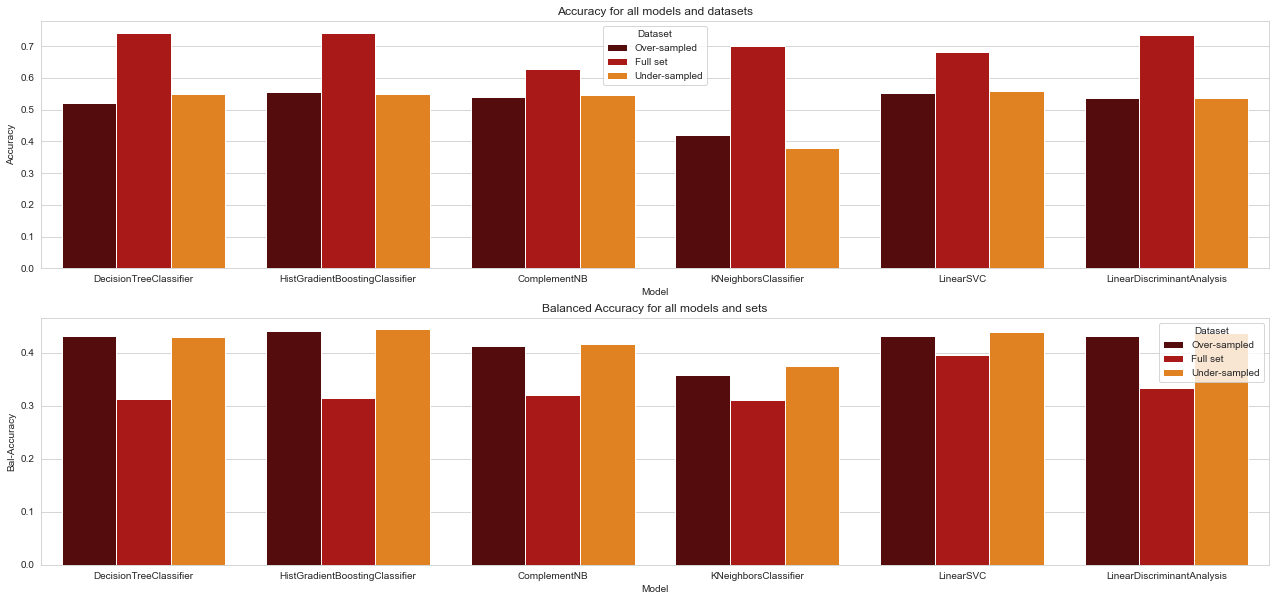

In [94]:
# Plotting Accuracy and Balanced Accuracy
#
fig, (ax1,ax2) = plt.subplots(2, 1)
fig.set_size_inches(22, 10)
# Plotting Accuracy
my_ax1 = sns.barplot(x='Model', y='Accuracy', data=clasf_ave_results, hue='Dataset', 
                palette='gist_heat', ax=ax1)        
my_ax1.set(xlabel='Model', ylabel='Accuracy')
my_ax1.set_title('Accuracy for all models and datasets')
#  Plotting Balanced Accuracy
my_ax2 = sns.barplot(x='Model', y='Bal-Accuracy', data=clasf_ave_results, hue='Dataset', 
                palette='gist_heat', ax=ax2)
my_ax2.set(xlabel='Model', ylabel='Bal-Accuracy')
my_ax2.set_title('Balanced Accuracy for all models and sets')

From the plots is clear that the accuracy metric determines that the Full set dataset is the best option, independent of the method. This is contrary to the results of balanced accuracy, which shows than the Over-sampled and Under-sampled datasets are better with any algorithm. This difference is due to the fact that accuracy is not taking into account the poor performance of minority classes with the Full set dataset.

In terms of the algorithms, the accuracy metric shows that DecisionTreeClassifier, HistGradientBoostingClassifier and LinearDiscriminantAnalysis are the best methods with the full set. The balanced accuracy metric identifies DecisionTreeClassifier, HistGradientBoostingClassifier, LinearSVC and LinearDiscriminantAnalysis as the best algorithms with the Over-sampled and Under-sampled datasets.

The next cells show the analysis done to get more details and a closer look at the results. The first part of the analysis will examine average metrics across the classes, just as a point of reference and the second part will calculate for the metrics at the class level, that should be a more reliable performance metric.

Next to determine the combination of dataset type and model that provides the best performance, using average metrics. The code adds all the average metrics for each scenario (combination of dataset type and algorithm) and sort the results. 

##### ==== Best scenario with average values ====

In [95]:
#
# finding the best scenario for average values by adding scores of different metrics
#
list_col = ['Ave. Precision', 'Ave. Recall', 'Ave. f1-score', 'Accuracy']
clasf_ave_results['Tot_metric'] = clasf_ave_results[list_col].sum(axis=1)
total_metrics=clasf_ave_results.sort_values('Tot_metric', ascending=False)
total_metrics.head()

,Dataset,Model,Ave. Precision,Ave. Recall,Ave. f1-score,Accuracy,Bal-Accuracy,Tot_metric
7,Full set,HistGradientBoostingClassifier,0.695612,0.741517,0.680605,0.741517,0.315352,2.859252
6,Full set,DecisionTreeClassifier,0.693419,0.741395,0.680640,0.741395,0.313124,2.856849
11,Full set,LinearDiscriminantAnalysis,0.697391,0.734223,0.672370,0.734223,0.333089,2.838207
10,Full set,LinearSVC,0.695317,0.680212,0.662303,0.680212,0.395634,2.718044
9,Full set,KNeighborsClassifier,0.646739,0.700504,0.661910,0.700504,0.310023,2.709657


The table above indicates that using average metrics, the scenario with the Full set data and model HistGradientBoostingClassifier is the best. 

Next the confusion matrix for this scenario is shown.

##### ==== Confusion matrix for best scenario average metrics ====


Start  20:30:26
Finish:  20:36:53   Calculation time:  00:06:26


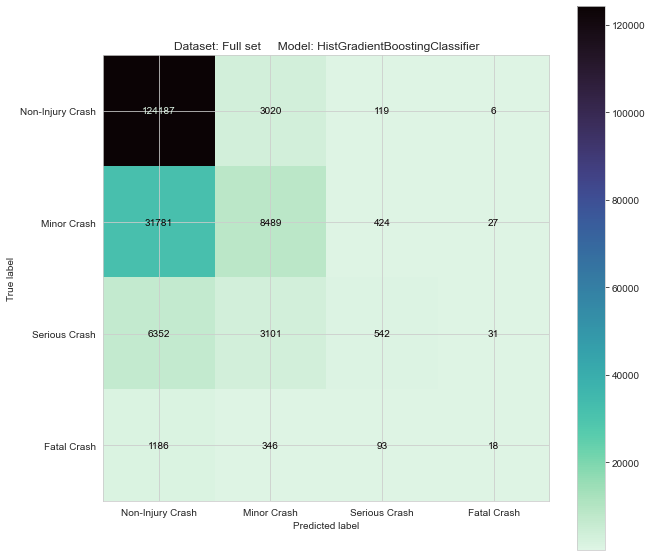

In [96]:
# Plot confusion matrix for scenario HistGradientBoostingClassifier - Full Set
#
name_model = HistGradientBoostingClassifier()
name_data = 'Full set'
confus_matx(name_data, name_model, X_train_full_ohe, y_train_full, X_test_full_ohe, y_test_full)


From the confusion matrix is clearly visible the large majority of the Non-Injury Crash samples are correctly predicted (124150) while only 27 Fatal Crash samples are. The matrix indicates that only the Non-Injury Crash has a high percentage of correct prediction (97.5%), while Minor Crash is only 20.9%, Serious Crash 5.2% and Fatal Crash 1.6%. The matrix indicates that most of the miscalculated samples from Minor Crash, Serious Crash and Fatal Crash are labelled as Non-Injury Crash. However, the accuracy score is 0.74, which is a good score. As summary is possible to say that the scenario of Full set dataset and algorithm HistGradientBoostingClassifier is totally skewed and will be of not use for the purpose of this project as it cannot identify properly the most critical classes and misclassify many critical ones as Non-Injury.

Now the analysis using the most appropriate metrics, the ones at the class level. There are values of precision, recall and f1-score for each class on each of the scenarios of dataset type and model. On each instance the per class metrics are added together, after the totals for Fatal Crash and Serious Crash instances are ranked and compared to select a scenario that benefits the two classes the most.

##### ==== Best scenario with per class metrics ====

In [97]:
#
# Finding the best scenario using metrics at the class level, providing better information
# about the performance of each class, especially the minority ones.
# For each scenario the sum of the metrics
# is calculated and the top scenarios for the two minorities are compared and the best top
# mutual scenarios are chosen.
#
list_col = ['Precision', 'Recall', 'f1-score']
clasf_results['Tot_metric'] = clasf_results[list_col].sum(axis=1)
by_severity = clasf_results.groupby('Severity')
sev_group = ['Fatal Crash', 'Serious Crash', 'Minor Crash', 'Non-Injury Crash']
danger_class = pd.DataFrame(columns=['Dataset', 'Model', 'Severity', 'Tot_metric', 'Recall',
                                    'f1-score', 'Precision'])
for sev_class in sev_group:
    scene_class = by_severity.get_group(sev_class)
#    print(sev_class)
    short_scene_class = scene_class[['Dataset', 'Model', 'Severity', 'Tot_metric', 'Recall',
                                     'f1-score','Precision']]
#    print(short_scene_class.iloc[:5,:])
    if sev_class in sev_group[0:2]:
        short_scene_class.sort_values('Tot_metric', ascending=False, inplace=True)
        danger_class = danger_class.append(short_scene_class.iloc[0:7,:])
# print(danger_class) 
for row_fatal in range(0,7):
    testdata = danger_class.iloc[row_fatal,0]
    testmodel = danger_class.iloc[row_fatal,1]
    for row_ser in range(7,14):
        if testdata == danger_class.iloc[row_ser,0] and testmodel == danger_class.iloc[row_ser,1]:
            print('\n\n A possible candidate =============')
            print('Dataset: ', testdata, '  Model: ', testmodel, '\n   Total score: ', 
                 danger_class.iloc[row_fatal, 3] + danger_class.iloc[row_ser, 3], '\n')
            print(danger_class.iloc[row_fatal,2::])
            print(danger_class.iloc[row_ser,2::])          




 A possible candidate =============
Dataset:  Under-sampled   Model:  LinearSVC 
   Total score:  1.4331439005153177 

Severity      Fatal Crash
Tot_metric       0.707509
Recall           0.631771
f1-score        0.0498105
Precision       0.0259273
Name: 67, dtype: object
Severity      Serious Crash
Tot_metric         0.725635
Recall             0.320666
f1-score           0.228038
Precision           0.17693
Name: 66, dtype: object


 A possible candidate =============
Dataset:  Over-sampled   Model:  DecisionTreeClassifier 
   Total score:  1.4149844035965913 

Severity      Fatal Crash
Tot_metric       0.693025
Recall           0.625076
f1-score        0.0447456
Precision       0.0232033
Name: 3, dtype: object
Severity      Serious Crash
Tot_metric         0.721959
Recall             0.309196
f1-score           0.229851
Precision          0.182912
Name: 2, dtype: object


 A possible candidate =============
Dataset:  Over-sampled   Model:  LinearSVC 
   Total score:  1.40328582080

From the analysis the best option to find a compromise improving the performance of the minority classes, 'Fatal Crash' and 'Serious Crash', is the scenario with Under-sampled dataset and the LinearSVC model. Below is the confusion matrix for this scenario.

##### ==== Confusion matrix for best scenario using metrics at class level ====


Start  20:36:55
Finish:  20:36:59   Calculation time:  00:00:04


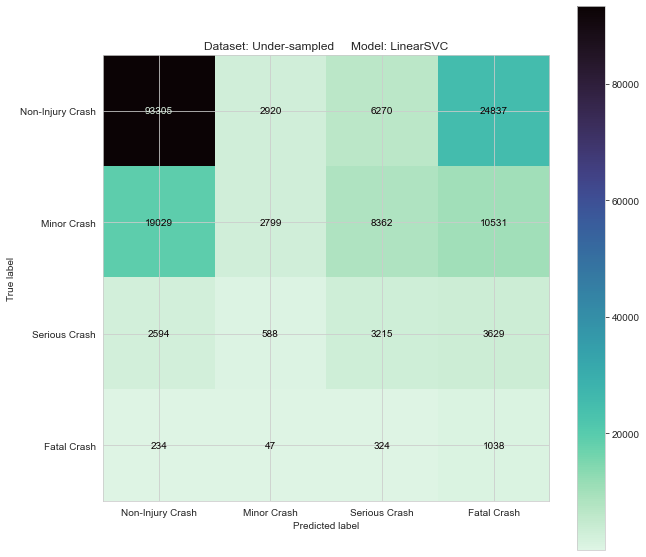

In [98]:
# Calculating the confusion matrix for scenario with algortihm LinearSVC and Under-sampled set
name_model = LinearSVC()
name_data = 'Under-sampled'
confus_matx(name_data, name_model, X_train_under_ohe, y_train_under, X_test_full_ohe, y_test_full)


The results show that using metrics at the class level has improved the performance of Serious Crash and Fatal Crash classes with the detriment of Minor Crash and Non-Injury Crash. One important issue is the high misclassification of other classes as Fatal Crash. In terms of correct predictions the percentages are now 73.3% for Non-Injury Crash, 6.9% for Minor Crash, 32% for Serious and 63.2% for Fatal Crash. These percentages are a lot better than the previous scenario for the minority classes. Using this scenario there are 1038 correct predicted Fatal Crash samples compare with the only 27 samples from the previous scenario. Even if this issue has improved, a new problem is that there are close to 40000 misclassified samples as Fatal Crash. This makes this model and companion dataset not reliable as it means that for a lot of crashes emergency services will be dispatched when they are not required. 

##### ==== Comparison of the selected scenario using average metrics vs selected scenario using per class metrics ====
Below are plots showing the precision, recall and f1-score at the class level for the two selected algorithms: 1) HistGradientBoostingClassifier and 2) LinearSVC and the three datasets: Full set, Over-sampled and Under-sampled.

The colours correspond to:
- Blue --> precision values for all the classes
- Red --> recall values for all the classes
- Green --> f1-score values for all the classes

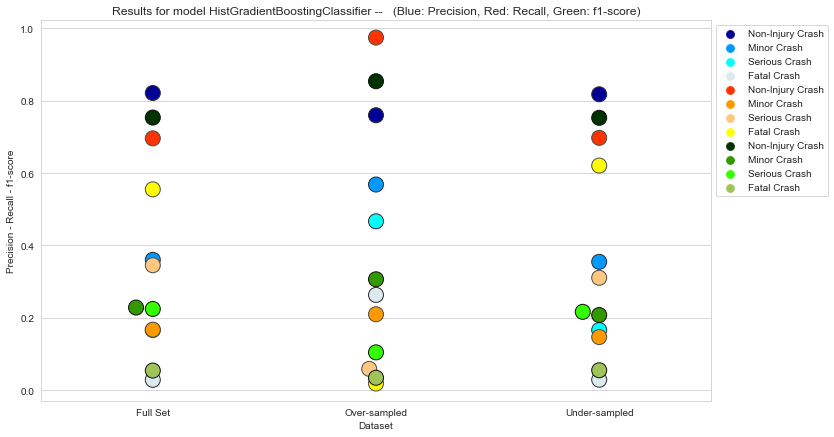

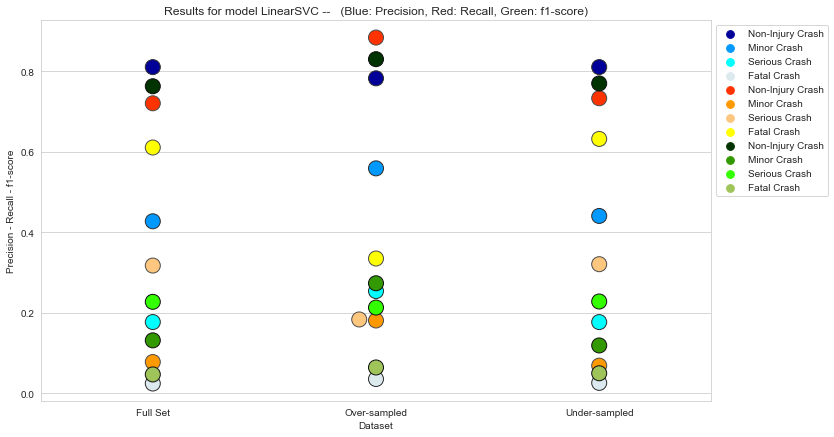

In [99]:
# Plots of class metrics for the two selected scenarios
#
by_model = clasf_results.groupby('Model')
model_histG = by_model.get_group('HistGradientBoostingClassifier')
# model_hi=stG.head()
model_LiSVC = by_model.get_group('LinearSVC')
colmena(model_histG, 'HistGradientBoostingClassifier')
colmena(model_LiSVC, 'LinearSVC')

Comparing values of the HistGradientBoostingClassifier/Full set with the ones from LinearSVC/Under-sampled is possible to notice that the three metrics (precision, recall and f1-score) do not change visibly for Non-Injury Crash between the two scenarios, while the values for Fatal Crash show a big change for recall. Similarly there are important changes for Serious Crash.